First install all the necessary libraries

In [1]:
#!pip install Levenshtein
#!pip install pandas
#!pip install nltk
#!pip install Levenshtein
#!pip install textblob
#!pip install scikit-learn
#!pip install xgboost

In [2]:
#imports

import numpy as np
from textblob import TextBlob
import itertools
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors
import sklearn.neighbors
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import re
import os
import nltk
import Levenshtein
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
from scipy.interpolate import make_interp_spline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

Download the NLTK data.

In [3]:
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')

In [4]:
def read_file(file_path):
    
    with open(file_path, 'r') as file:
        text = file.read()
    return text

Choose the number of artists in the database.

In [5]:
#DEFINE A MAX NUMBER OF ARTISTS
NUMBER_OF_ARTISTS = 150

Now get the data. Note that for each artist folder, in the Songs subfolder, there are 2 files per song : the lyrics, and the RID (Regressive Imagery Dictionary) features.

In [6]:
#Get the data

path_to_songs = os.path.join(os.getcwd(), "Raw_Songs_DataBase")

artists = os.listdir(path_to_songs)
artists_all = [art for art in artists if art[0] != "."]
artists = random.sample(artists_all, NUMBER_OF_ARTISTS) #select the correct number of artists
artists = sorted(artists)

x = []
RID_features = []
y = []

songs_per_artist={art : 0 for art in artists}

titles = []

for art in artists: 
    

    path_to_artist = os.path.join(path_to_songs, art)
    path_to_artist_songs = os.path.join(path_to_artist, "Songs")
    
    songs = os.listdir(path_to_artist_songs)
    for song in songs:
        if song[0] != ".":
            if song[-3:] != "RID":
                path = os.path.join(path_to_artist_songs, song)
                titles.append(song)
                lyrics =  read_file(path)
                x.append(lyrics)
                songs_per_artist[art] += 1
                y.append(art)
            else: #is a RID file
                path = os.path.join(path_to_artist_songs, song)
                text =  read_file(path)
                RID_features.append(text)

    
arts_dict = {}
for i in range(len(artists)):
    arts_dict[artists[i]] = i
    
arts_dict_op = {i: artist for artist, i in arts_dict.items()}
    
for i in range(len(y)):
    art = y[i]
    y[i] = int(arts_dict[art])

x = np.array(x)
y = np.array(y) 
titles = np.array(titles)

assert len(x) == len(RID_features)

In [7]:
#Set the directory in which to save the plots
save_dir = os.path.join(os.getcwd(), "saved_plots")

Now let us see what our dataset looks like.

Number of songs : 16606
Number of artists : 150
Average number of songs per artist : 110
Maximum number of songs: 201
Minimum number of songs: 2


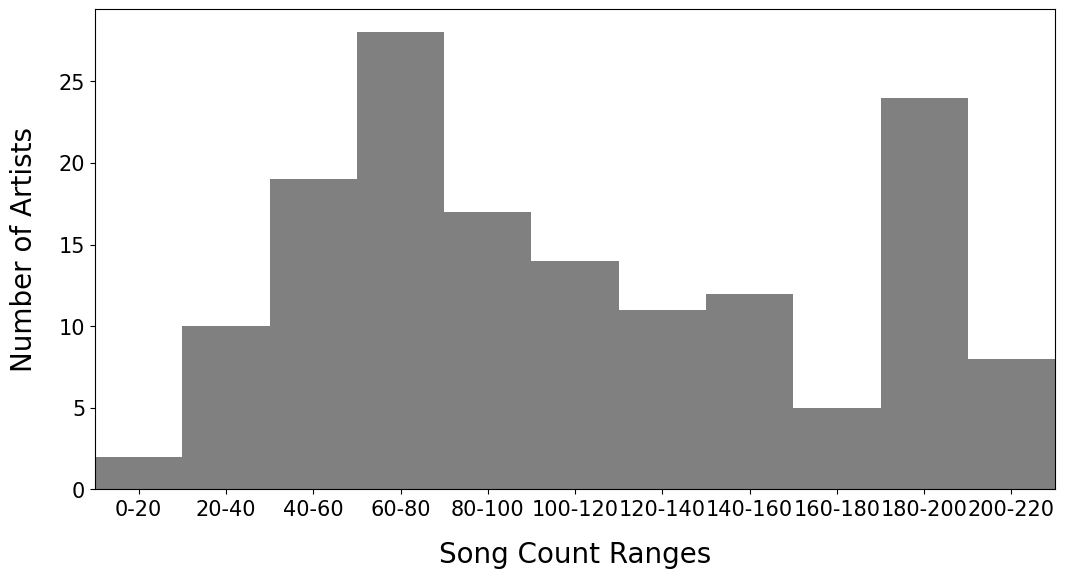

In [8]:
print(f'Number of songs : {len(x)}')
print(f'Number of artists : {len(artists)}')
print(f'Average number of songs per artist : {int(len(x)/len(artists))}')

max_value = max(songs_per_artist.values())
min_value = min(songs_per_artist.values())

print(f"Maximum number of songs: {max_value}")
print(f"Minimum number of songs: {min_value}")

# Define the bins for different song count ranges
max_bin = ((max_value // 20) + 1) * 20
bins = [i*20 for i in range((max_bin//20) + 1)]

# Initialize counts for each bin
bin_counts = [0] * (len(bins) - 1)

# Count the number of artists falling into each bin
for value in songs_per_artist.values():
    for i in range(len(bins) - 1):
        if bins[i] <= value < bins[i + 1]:
            bin_counts[i] += 1
            break

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

bar_lefts = range(len(bin_counts))
bar_heights = bin_counts

plt.bar(bar_lefts, bar_heights, width=1.0, facecolor='gray')

plt.xlabel('Song Count Ranges', fontsize=20, labelpad=15)
plt.ylabel('Number of Artists', fontsize=20, labelpad=15)

plt.xticks(range(len(bin_counts)), [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)], fontsize=15)
plt.yticks(fontsize=15)

plt.xlim(-0.5, len(bin_counts) - 0.5)

save_path = os.path.join(save_dir, f'distribution_songs_start.png')
plt.savefig(save_path, bbox_inches='tight')

plt.show()

We start processing our data.

In [9]:
#remove all that is into paranthesis in the titles
for i in range(len(titles)):
    titles[i] = re.sub(r'\([^()]+\)', '', titles[i]).strip()

In [10]:
def flatten(text):
    text = [word for sentence in text for word in sentence]
    return text

In [11]:
def pre_processing(text):
    
    text = text.lower() #lowercase
    
    #split in lines
    text = text.split("\n") 
    
    #remove useless punctuation
    punctuation = r'[/()-.?!,";{}]'
    text= [re.sub(punctuation,"", sentence) for sentence in text]
    
    #seperate each word
    text = [line.split(' ') for line in text]
    
    #flatten the list of lists

    
    #remove empty lines
    text = [line for line in text if len(line)!=0]
    
    
    #remove all expressions in between brackets and empty words
    text = [ [word.strip() for word in line if len(word) != 0 and word[0]!= "["] for line in text]
    
    #remobe empty lines again
    text = [line for line in text if len(line)!=0]
    nb_lines = len(text)
    
    #stemmatization
    ps = PorterStemmer()
    text = [[ps.stem(word) for word in line] for line in text]
    
    nb_words = 0
    for line in text:
        nb_words += len(line)


    return text, nb_lines, nb_words

def title_pre_processing(title):
    title = title.lower()  # lowercase
    #title = re.sub(r'\.txt$', '', title)  # remove .txt extension
    punctuation = r'[-.?!,";/]'
    title = re.sub(punctuation, "", title)
    title = re.sub(r'[\(\[].*?[\)\]]', '', title)
    title = title.strip()
    return title

In [12]:
data = []
for i in range(len(x)):
    song = x[i]
    point = list(pre_processing(song))
    point.append(song)
    t = title_pre_processing(titles[i])
    point.append(t)
    point.append(y[i])
    data.append(point)
    

In [13]:
df = pd.DataFrame(data, columns=['Lyrics', 'Nb_Lines', 'Nb_Words', 'Raw_Lyrics', 'Title', 'Artist'])
df.head()

Lyrics  Nb_Lines  Nb_Words  \
0  [[i, will, leav, my, heart, at, the, door], [i...        41       286   
1  [[i, know, you'v, got, thing, to, do, i, do, t...        26       168   
2  [[sha, la, la, la, la, la, la, la], [sha, la, ...        41       236   
3  [[wait, do, you, see, my, heart, on, my, sleev...        44       410   
4  [[if, fish, swam, out, of, the, ocean], [and, ...        52       318   

                                          Raw_Lyrics              Title  \
0  \nI will leave my heart at the door\nI won't s...          all i ask   
1  \nI know you've got things to do (I do too)\nI...  all night parking   
2  \nSha la la la la la la la\nSha la la la la la...      baby it's you   
3  \nWait, do you see my heart on my sleeve?\nIt'...      best for last   
4  \nIf fish swam out of the ocean\nAnd grew legs...       black & gold   

   Artist  
0       0  
1       0  
2       0  
3       0  
4       0

We write functions to plot features in a box plot and a bar plot.

In [14]:
def plot_box_graph(features, save=None):
    
    nb_graphs = len(features)
    if nb_graphs == 1:
        feature = features[0]
        to_plot = []
        for art in sample:
            d1 = df.loc[df['Artist'] == art, feature]
            to_plot.append(d1.tolist())
        plt.boxplot(to_plot)
        xtick_labels = [arts_dict_op[i] for i in sample]
        plt.gca().set_xticklabels(xtick_labels, rotation='vertical', fontsize=8)
        plt.title(feature)
        if save != None:
            save_path = os.path.join(save_dir, f'plot_{features}.png')
            plt.savefig(save_path, bbox_inches='tight')

        plt.show()
    else:
        fig, graphs = plt.subplots(1, nb_graphs, figsize=(10, 4), gridspec_kw={'wspace': 0.3})
    
        plots = [[] for _ in range(nb_graphs)]

        for art in sample:
            for i in range(len(features)):
                feature = features[i]
                d = df.loc[df['Artist'] == art, feature]
                plots[i].append(d)
        
        for i in range(len(plots)):
            graphs[i].boxplot(plots[i])

        xtick_labels = [arts_dict_op[i] for i in sample]
        
        for i in range(len(features)):
            feature = features[i]
            graphs[i].set_xticklabels(xtick_labels, rotation='vertical', fontsize=8)
            graphs[i].set_title(feature)

        if save != None:
            save_path = os.path.join(save_dir, f'plot_{features}.png')
            plt.savefig(save_path, bbox_inches='tight')

        
        plt.show()
        
def plot_bar_graph(feature, save = None):

    to_plot = []
    for art in sample:
        d1 = df.loc[df['Artist'] == art, feature]
        to_plot.append(d1.mean())

   
    plt.bar(np.arange(len(to_plot)), to_plot, color='gray')
    xtick_labels = [arts_dict_op[i] for i in sample]
    plt.xticks(np.arange(len(to_plot)), xtick_labels, rotation='vertical', fontsize=8)
    plt.title(feature)
    
    if save != None:
        save_path = os.path.join(save_dir, f'plot_{feature}.png')
        plt.savefig(save_path)

    plt.show()

Now we parse the RID features and add them to the dataframe.

In [15]:
#let's add the RID columns
def RID_dict(text):
    text = text.split("\n")
    text = [re.findall(r'\d+(?:\.\d+)?|\D+', t) for t in text]
    #text = [t.split(' ') for t in text if len(t)!=0 and t[0].isupper()]
    text = [[word.strip() for word in t if re.match(r'^[A-Z0-9.]', word)] for t in text]
    text = [arr for arr in text if len(arr) != 0]
    summary = text[-4:-1]
    details = text[:-4]
    lenght = text[-1][0]
    details = [ [word.replace(' ', ':') for word in line] for line in details]
    summary = [ [s.replace(':', '').strip() for s in line] for line in summary]
    summary = [ [s.replace(':', '').strip() for s in line] for line in summary]

    details = {d[0] : (int(d[1]))/(int(lenght)) for d in details}
    #details = {d[0] : int(d[1]) for d in details}
    summary = {d[0] : float(d[1]) for d in summary}
    
    return details, summary

RID_DETAILS = {}
RID_SUMMARY = {'RID_PRIMARY': [], 'RID_SECONDARY' : [], 'RID_EMOTIONS' : []}

#first let's get the labels
for rid in RID_features:
    d, s = RID_dict(rid)
    for key in d.keys():
        if key not in RID_DETAILS.keys():
            RID_DETAILS['RID_'+key] = []

#now fill in the values
for rid in RID_features:
    d, s = RID_dict(rid)
    for key in RID_DETAILS.keys():
        if key[4:] in d.keys():
            RID_DETAILS[key].append(d[key[4:]])
        else:
            RID_DETAILS[key].append(0)
    for key in s.keys():
        RID_SUMMARY['RID_'+key].append(s[key])


In [16]:
df = df.assign(**RID_DETAILS)
df = df.assign(**RID_SUMMARY)
df.head()

Lyrics  Nb_Lines  Nb_Words  \
0  [[i, will, leav, my, heart, at, the, door], [i...        41       286   
1  [[i, know, you'v, got, thing, to, do, i, do, t...        26       168   
2  [[sha, la, la, la, la, la, la, la], [sha, la, ...        41       236   
3  [[wait, do, you, see, my, heart, on, my, sleev...        44       410   
4  [[if, fish, swam, out, of, the, ocean], [and, ...        52       318   

                                          Raw_Lyrics              Title  \
0  \nI will leave my heart at the door\nI won't s...          all i ask   
1  \nI know you've got things to do (I do too)\nI...  all night parking   
2  \nSha la la la la la la la\nSha la la la la la...      baby it's you   
3  \nWait, do you see my heart on my sleeve?\nIt'...      best for last   
4  \nIf fish swam out of the ocean\nAnd grew legs...       black & gold   

   Artist  RID_EMOTIONS:AFFECTION  RID_SECONDARY:SOCIAL:BEHAVIOR  \
0       0                0.049834                       0.029900   
1       0                0.005525                       0.005525   
2       0                0.003968                       0.019841   
3       0                0.013514                       0.018018   
4       0                0.000000                       0.002933   

   RID_SECONDARY:ABSTRACTION  RID_SECONDARY:TEMPORAL:REFERENCES  ...  \
0                   0.029900                           0.023256  ...   
1                   0.022099                           0.033149  ...   
2                   0.023810                           0.011905  ...   
3                   0.027027                           0.013514  ...   
4                   0.032258                           0.035191  ...   

   RID_PRIMARY:ICARIAN:IMAGERY:FIRE  RID_PRIMARY:SENSATION:ODOR  \
0                               0.0                         0.0   
1                               0.0                         0.0   
2                               0.0                         0.0   
3                               0.0                         0.0   
4                               0.0                         0.0   

   RID_SECONDARY:ORDER  RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:DIFFUSION  \
0                  0.0                                            0.0   
1                  0.0                                            0.0   
2                  0.0                                            0.0   
3                  0.0                                            0.0   
4                  0.0                                            0.0   

   RID_EMOTIONS:SADNESS  RID_PRIMARY:REGRESSIVE:COGNITION:UNKNOWN  \
0                   0.0                                       0.0   
1                   0.0                                       0.0   
2                   0.0                                       0.0   
3                   0.0                                       0.0   
4                   0.0                                       0.0   

   RID_PRIMARY:NEED:ANALITY  RID_PRIMARY  RID_SECONDARY  RID_EMOTIONS  
0                       0.0    16.666667      51.666667     31.666667  
1                       0.0    50.000000      36.842105     13.157895  
2                       0.0    32.142857      53.571429     14.285714  
3                       0.0    31.506849      57.534247     10.958904  
4                       0.0    48.101266      30.379747     21.518987  

[5 rows x 52 columns]

Add a new feature and remove the empty songs.

In [17]:
df = df[df["Nb_Words"] != 0]
df["Nb_Words_Per_Line"] = df["Nb_Words"]/df["Nb_Lines"]

Clean the dataset.

In [18]:
s1 = df.shape[0]
df = df.drop_duplicates(subset=['Title', 'Artist'])
s2 = df.shape[0]
print(f'Dropped {s1 - s2} duplicates')

raw_songs = df["Raw_Lyrics"].to_list()

Dropped 212 duplicates


In [19]:
df = df[df['Nb_Words'] >= 50]
s3 = df.shape[0]

print(f'Dropped {s2 - s3} songs that were too short')

df = df[~df['Title'].str.contains('intro', case=False)]
df = df[~df['Title'].str.contains('outro', case=False)]
s4 = df.shape[0]

print(f'Dropped {s3 - s4} intros and outros')

Dropped 356 songs that were too short
Dropped 19 intros and outros


In [20]:
def dropping_artists():
    
    artist_counts = df['Artist'].value_counts()

    # remove all artists that have less than 80 songs
    artists_to_drop = artist_counts[artist_counts < 80].index

    # Create a boolean mask indicating rows to be dropped
    mask = df['Artist'].isin(artists_to_drop)

    # Filter and drop the corresponding rows from the DataFrame
    df.drop(df[mask].index, inplace=True)

    l1 = len(artists)
    # Remove the artists from the artists array
    new_artists = [art for art in artists if arts_dict[art] not in artists_to_drop]
    dropped_artists = [art for art in artists if arts_dict[art] in artists_to_drop]
    for art in dropped_artists:
        del arts_dict_op[arts_dict[art]]
        del arts_dict[art]

    l2 = len(new_artists)


    s5 = df.shape[0]
    print(f'Dropped {l1 - l2} artists that had too few songs : -{s4 - s5} songs')
    
dropping_artists()

Dropped 61 artists that had too few songs : -3185 songs


In [21]:
#FUNCTIONS TO MEASURE SIMILARITY

def levenshtein_similarity(text1, text2):
    distance = Levenshtein.distance(text1, text2)
    max_length = max(len(text1), len(text2))
    similarity = (max_length - distance) / (max_length + 1)
    return similarity

def jaccard_similarity(text1, text2):
    set1 = set(text1)
    set2 = set(text2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    similarity = intersection / (union + 1)
    return similarity

We remove covers.

In [22]:
mask = np.zeros(len(df), dtype=bool)

for idx1, row1 in df.iterrows():
    song1 = row1["Raw_Lyrics"]
    title1 = row1["Title"]
    artist1 = row1["Artist"]
    
    # keep same title but different artist
    duplicate_rows = df[(df["Title"] == title1) & (df["Artist"] != artist1)]
    
    # calculate similarity scores between two songs with the same title
    similarity_scores_lev = duplicate_rows["Raw_Lyrics"].apply(lambda x: levenshtein_similarity(song1, x))
    
    # get rows with similarity scores above 0.8
    similar_rows_lev = duplicate_rows[similarity_scores_lev > 0.8]

    df.drop(similar_rows_lev.index, inplace=True)

s3 = df.shape[0]
print(f'Dropped {s2 - s3} covers')

Dropped 3733 covers


In [23]:
#OPTIONAL : we can also choose to undersample artists that are too represented

def undersampling():
    # Identify artists with a total number of songs greater than 130
    artists_above_threshold = artist_counts[artist_counts > 130].index

   
    for artist in artists_above_threshold:
        # Get the indices of songs by the current artist
        artist_indices = df[df['Artist'] == artist].index

        # Calculate the number of songs to be dropped
        songs_to_drop = len(artist_indices) - 130

        # Randomly select and drop songs until count reaches 130
        songs_to_keep = np.random.choice(artist_indices, size=130, replace=False)
        df.drop(artist_indices.difference(songs_to_keep), inplace=True)

    s7 = df.shape[0]
    print(f'Dropped {s6 - s7} songs from undersampling too represented artists')

Let us see the final dataset.

In [24]:
artist_counts = df['Artist'].value_counts()

artist_most_songs = artist_counts.idxmax()
most_songs_count = artist_counts.max()

artist_least_songs = artist_counts.idxmin()
least_songs_count = artist_counts.min()

print(f"Artist with the most songs: {artists[artist_most_songs]} ({most_songs_count} songs)")
print(f"Artist with the least songs: {artists[artist_least_songs]} ({least_songs_count} songs)")

Artist with the most songs: Dolly Parton (199 songs)
Artist with the least songs: Parquet Courts (80 songs)


In [25]:
print("AFTER CLEANING\n")

print(f'Number of songs : {df.shape[0]}')
print(f'Number of artists : {len(arts_dict)}')
print(f'Average number of songs per artist : {int((df.shape[0])/len(arts_dict))}')

AFTER CLEANING

Number of songs : 12657
Number of artists : 89
Average number of songs per artist : 142


Let us check the most important RID features.

In [26]:
df_rid = df.filter(regex=r'^RID')

pca = PCA(n_components=len(df_rid.columns))

pca.fit(df_rid)

# get the explained variance ratio of each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# sort the variance ratios in descending order
sorted_variance_ratio = sorted(explained_variance_ratio, reverse=True)

# Get the indices of the top 10 features with the most variance
top_10_indices = np.argsort(explained_variance_ratio)[::-1][:10]

# Keep only the top 10 features in the DataFrame
df_top_10 = df_rid.iloc[:, top_10_indices]
print('Top 10 RID features:')
for rid in df_top_10.columns:
    print(rid)

Top 10 RID features:
RID_EMOTIONS:AFFECTION
RID_SECONDARY:SOCIAL:BEHAVIOR
RID_SECONDARY:ABSTRACTION
RID_SECONDARY:TEMPORAL:REFERENCES
RID_SECONDARY:INSTRUMENTAL:BEHAVIOR
RID_PRIMARY:REGRESSIVE:COGNITION:NARCISSISM
RID_EMOTIONS:ANXIETY
RID_PRIMARY:SENSATION:VISION
RID_PRIMARY:SENSATION:SOUND
RID_PRIMARY:REGRESSIVE:COGNITION:CONCRETENESS


We add a new feature: Type-Token ratio. It shows how repetitive a song is.

In [27]:
songs = df["Lyrics"].to_list()
songs_flatten = [[word for line in song for word in line] for song in songs]
nb_words = df["Nb_Words"].to_list()

#unique word means appears only once in the song
TTR = []
for song, l in zip(songs_flatten, nb_words):
    if l == 0:
        print(song)
    dic = {word: 0 for word in song}
    non_unique_words = set()
    for word in song:
        dic[word] += 1
        if dic[word] > 1: #if it appeared more than once, add it
            non_unique_words.add(word)
    nb_unique_words = l - len(non_unique_words)
    ttr = nb_unique_words / l
    TTR.append(ttr)
    
df['TTR'] = TTR

For visualisation purposes, we will only plot the data for 10 random artists.

In [28]:
if NUMBER_OF_ARTISTS > 10:
    sample = random.sample(list(arts_dict_op.keys()), 10)
else:
    sample = random.sample(list(arts_dict_op.keys()), NUMBER_OF_ARTISTS)

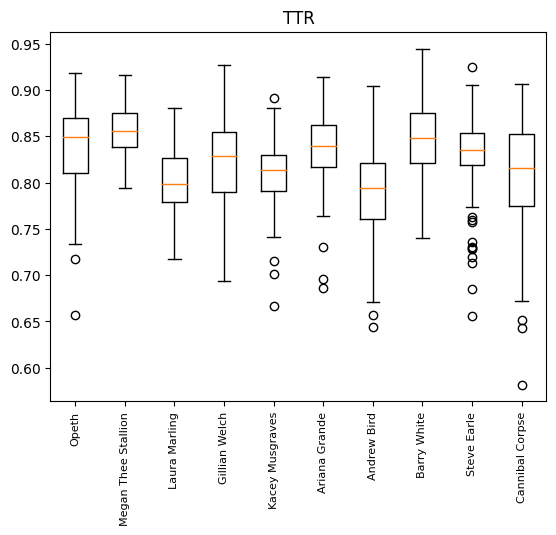

In [29]:
plot_box_graph(["TTR"], save = False)

Add the lines similarity.

In [30]:
raw_songs = df["Raw_Lyrics"].to_list()
nb_lines = df["Nb_Lines"].to_list()

lines_similarity_jacc = []

examples = []

for song, num_lines in zip(songs, nb_lines):
    line_similarity_count_jacc = 0
    
    for line1, line2 in itertools.combinations(song, 2):
        similarity_jacc = jaccard_similarity(line1, line2)
        
        
        if  similarity_jacc > 0.5:  # adjust the threshold as needed
            line_similarity_count_jacc += 1
            examples.append([line1, line2])
    
    lines_similarity_jacc.append(line_similarity_count_jacc)
    

df["Lines_similarity"] = lines_similarity_jacc

We look at some examples of what two similar lines can be.

In [31]:
reduced_examples = random.choices(examples, k=5)
for ex in reduced_examples:
    for l in ex:
        print(l)
    print("\n")

['get', 'down', 'on', 'it']
['get', 'down', 'on', 'it']


['can', 'you', 'love', 'realli', 'love', 'a', 'virgin', 'man']
['can', 'you', 'love', 'a', 'virgin', 'man']


['turn', 'me', 'up', 'in', 'the', 'headphon']
['turn', 'me', 'up', 'in', 'the', 'headphon']


['what', 'is', 'soul']
['what', 'is', 'soul']


['race', 'on', 'to', 'my', 'end']
['race', 'on', 'to', 'my', 'end']




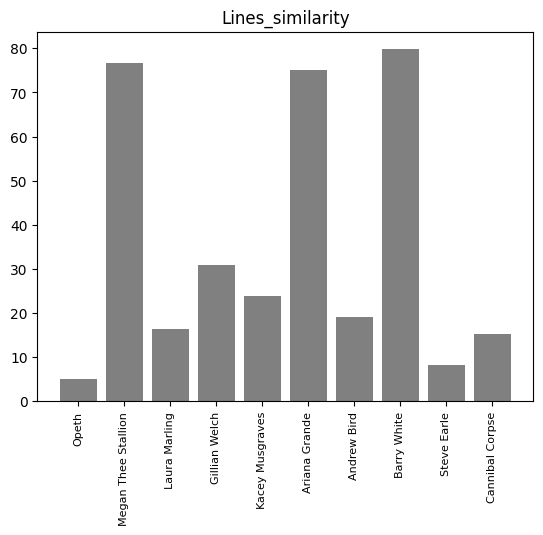

In [32]:
plot_bar_graph("Lines_similarity")

We add the POS (Part Of Speech) tags and the part of speech tags.

In [33]:
supertags_dict = {
    'VB': 'V', 'VBD': 'V', 'VBG': 'V', 'VBN': 'V', 'VBP': 'V', 'VBZ': 'V', #verbs
    'NN': 'N', 'NNS': 'N', 'NNP': 'N', 'NNPS': 'N', #nouns
    'RB': 'ADV', 'RBR': 'ADV', 'RBS': 'ADV', 'WRB': 'ADV', #adverbs
    'JJ': 'ADJ', 'JJR': 'ADJ', 'JJS': 'ADJ', #adjectives
    'DT': 'DET', 'PDT': 'DET', 'WDT': 'DET', #determinents
    'PRP': 'PRON', 'PRP$': 'PRON', 'WP': 'PRON', 'WP$': 'PRON'} #pronouns

supertags = ['N', 'V', 'ADV', 'ADJ', 'DET', 'PRON']
chunk_tags = ['GPE', 'PERSON', 'ORGANIZATION', 'LOCATION', 'FACILITY', 'GSP']

#'GPE': 'Geopolitical Entity: Refers to countries, cities, states, or regions.',
#'PERSON': 'Person: Refers to individuals or groups of people.',
#'ORGANIZATION': 'Organization: Refers to named entities representing companies, institutions, or groups.',
#'LOCATION': 'Location: Refers to specific places or locations.',
#'FACILITY': 'Facility: Refers to buildings, structures, or other physical facilities.',
#'GSP': 'General Single Purpose: Refers to a general chunk tag with a single-purpose label.'

def split_sentences(text):

    text = re.sub(r'\([^()]*\)', ' ', text)
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    text = text.replace('  ', ' ')
    sentences = re.split(r'(?:[.!?])|\n\n', text)
    sentences = [s.strip() for s in sentences if len(s)!=0]
    return sentences

In [34]:
def pos_chunk(text):
    # tokenize into sentences and words
    sentences = split_sentences(text)
    words = [nltk.word_tokenize(sent) for sent in sentences]
    
    # POS tagging
    pos_tags = [nltk.pos_tag(sent) for sent in words]
    
    # chunking
    chunked_sentences = [nltk.ne_chunk(pos_tag_sent) for pos_tag_sent in pos_tags]

    # calculate POS tag distribution
    pos_tag_distribution = {suptag: 0 for suptag in supertags}
    for sent in pos_tags:
        pos_tag_distribution.update({supertags_dict[tag]: pos_tag_distribution.get(supertags_dict[tag], 0) + 1
                                     for _, tag in sent if tag in supertags_dict})

    # calculate chunk tag distribution
    chunk_tag_distribution = {chunk_tag: 0 for chunk_tag in chunk_tags}
    for sent in chunked_sentences:
        chunk_tag_distribution.update({chunk.label(): chunk_tag_distribution.get(chunk.label(), 0) + 1
                                       for chunk in sent if hasattr(chunk, 'label') and chunk.label() in chunk_tags})

    return pos_tag_distribution, chunk_tag_distribution


In [35]:
raw_songs = df["Raw_Lyrics"].to_list()
#df = df.drop("Raw_Lyrics", axis = 1)
nb_words = df["Nb_Words"].to_list()

POS = {'POS_'+key : [] for key in supertags}

CHUNK = {'CHUNK_'+key : [] for key in chunk_tags}

for raw, l in zip(raw_songs, nb_words):
    pos, chunk = pos_chunk(raw)
    for key in pos.keys():
        POS['POS_'+key].append(pos[key] / l)
        
    for key in chunk.keys():
        CHUNK['CHUNK_'+key].append(chunk[key] / l)

In [36]:
df = df.assign(**POS)
df = df.assign(**CHUNK)
df.columns

Index(['Lyrics', 'Nb_Lines', 'Nb_Words', 'Raw_Lyrics', 'Title', 'Artist',
       'RID_EMOTIONS:AFFECTION', 'RID_SECONDARY:SOCIAL:BEHAVIOR',
       'RID_SECONDARY:ABSTRACTION', 'RID_SECONDARY:TEMPORAL:REFERENCES',
       'RID_SECONDARY:INSTRUMENTAL:BEHAVIOR',
       'RID_PRIMARY:REGRESSIVE:COGNITION:NARCISSISM', 'RID_EMOTIONS:ANXIETY',
       'RID_PRIMARY:SENSATION:VISION', 'RID_PRIMARY:SENSATION:SOUND',
       'RID_PRIMARY:REGRESSIVE:COGNITION:CONCRETENESS',
       'RID_PRIMARY:REGRESSIVE:COGNITION:BRINK-PASSAGE',
       'RID_EMOTIONS:EXPRESSIVE:BEHAVIOR', 'RID_SECONDARY:MORAL:IMPERATIVE',
       'RID_EMOTIONS:AGGRESSION',
       'RID_PRIMARY:REGRESSIVE:COGNITION:CONSCIOUSNESS:ALTERATION',
       'RID_PRIMARY:SENSATION:HARD', 'RID_PRIMARY:SENSATION:GENERAL-SENSATION',
       'RID_EMOTIONS:POSITIVE:AFFECT', 'RID_PRIMARY:SENSATION:COLD',
       'RID_PRIMARY:NEED:ORALITY', 'RID_PRIMARY:ICARIAN:IMAGERY:ASCENT',
       'RID_PRIMARY:SENSATION:TOUCH', 'RID_PRIMARY:NEED:SEX',
       'RID_PRIMA

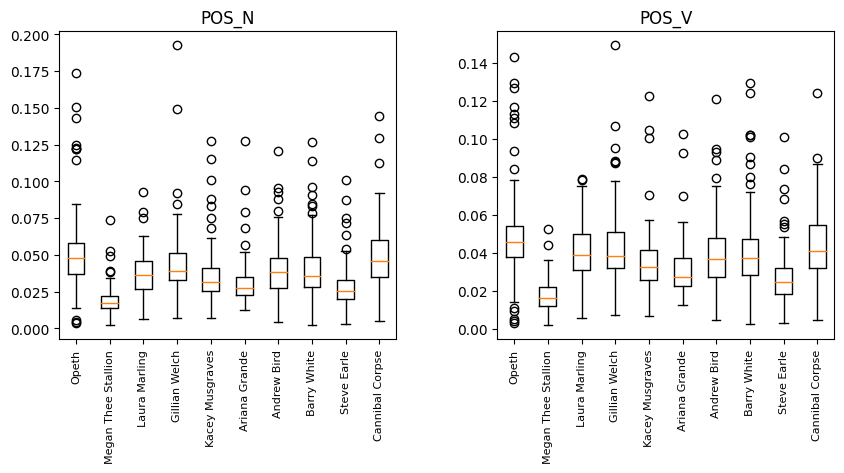

In [37]:
plot_box_graph(["POS_N", "POS_V"])

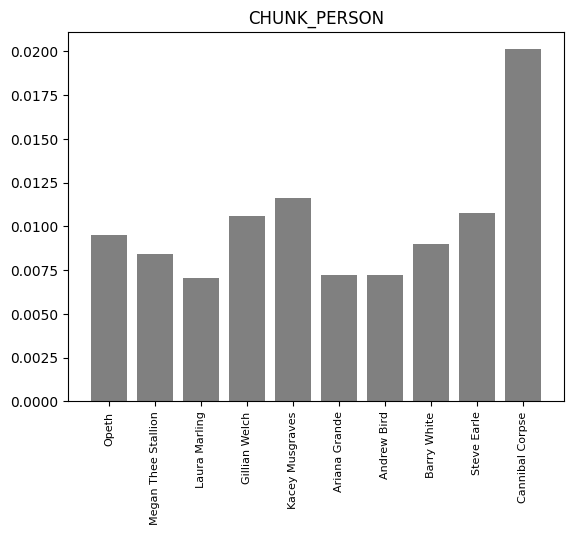

In [38]:
plot_bar_graph("CHUNK_PERSON")

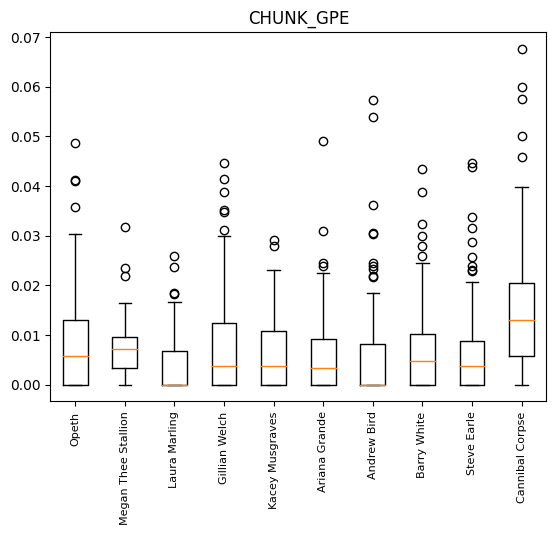

In [39]:
plot_box_graph(["CHUNK_GPE"])

We analyze the vocabulary of the songs : rare words and slang words.

In [40]:
path_to_dicts = os.path.join(os.getcwd(), "Dictionaries")

path = os.path.join(path_to_dicts, "rare-filtered.txt")
rare = read_file(path)
rare = rare.split("\n")
rare = rare[:-1]

path = os.path.join(path_to_dicts, "slang-filtered.txt")
slang = read_file(path)
slang = slang.split("\n")
slang = slang[:-1]

slang = set(slang)
rare = set(rare)

rare_use = []
slang_use = []

songs_flatten = [flatten(song) for song in songs] 
                 
for song in songs_flatten:
    
    count_r = 0
    count_s = 0
    l = len(song)
    for w in song:
        if w in slang:
            count_s += 1
        if w in rare:
            count_r +=1
    slang_use.append(count_s/l)
    rare_use.append(count_r/l)
    

df['Slang'] = slang_use
df['Rare'] = rare_use

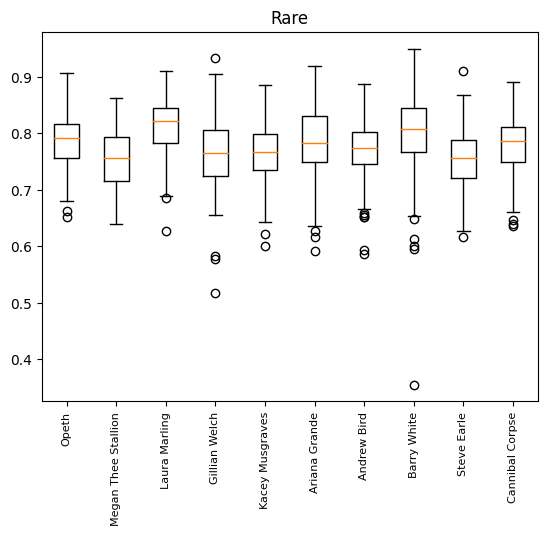

In [41]:
plot_box_graph(["Rare"])

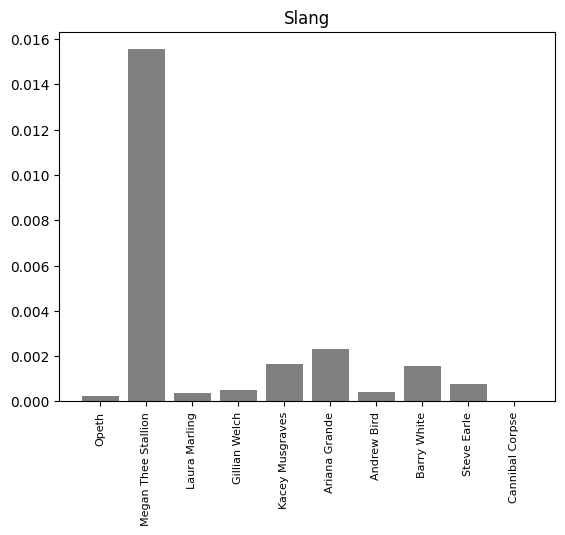

In [42]:
plot_bar_graph("Slang")

Now we check whether or not the title appears in the song.

In [43]:
ttls = df["Title"].to_list()

title_in_song = []

raw_songs = [s.lower() for s in raw_songs]


for song, title, art in zip(raw_songs, ttls, df["Artist"].to_list()):
    pattern = re.escape(title)  # Escape special characters in the title
    if re.search(pattern, song):
        flag = True
    else:
        flag = False
    title_in_song.append(flag)


df['Title_In_Song'] = title_in_song
                

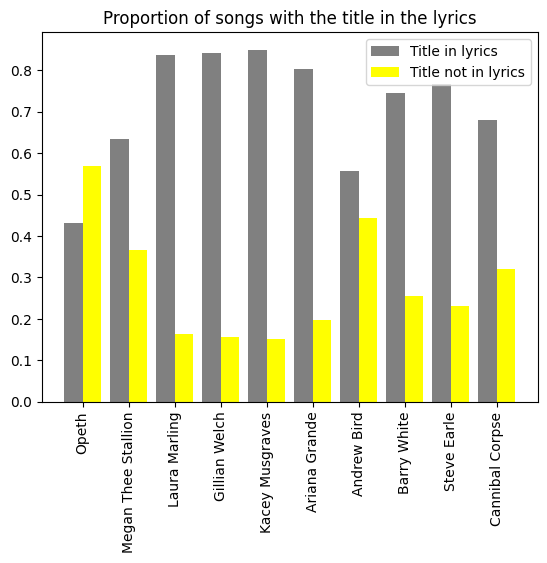

In [44]:
t_in = []
t_not_in = []
total_songs = []

for art in sample:
    songs_by_artist = df.loc[df['Artist'] == art, 'Title_In_Song'].tolist()
    tr = songs_by_artist.count(True)
    fa = songs_by_artist.count(False)
    total_songs.append(len(songs_by_artist))
    t_in.append(tr)
    t_not_in.append(fa)

xtick_labels = [arts_dict_op[i] for i in sample]

X_axis = np.arange(len(xtick_labels))

t_in = np.array(t_in)
t_not_in = np.array(t_not_in)
total_songs = np.array(total_songs)


plt.bar(X_axis - 0.2, t_in/total_songs, 0.4, label='Title in lyrics', color = "gray")
plt.bar(X_axis + 0.2, t_not_in/total_songs, 0.4, label='Title not in lyrics', color="yellow")

plt.xticks(X_axis, xtick_labels, rotation='vertical')
plt.title('Proportion of songs with the title in the lyrics')
plt.legend()
plt.show()
    

We add the subjectivity and polarity of the lyrics. 

In [45]:
sub = []
pol = []
for song in raw_songs:
    scores = TextBlob(song)
    pol.append(scores.sentiment.polarity)
    sub.append(scores.sentiment.subjectivity)
    
df["Polarity"] = pol
df["Subjectivity"] = sub

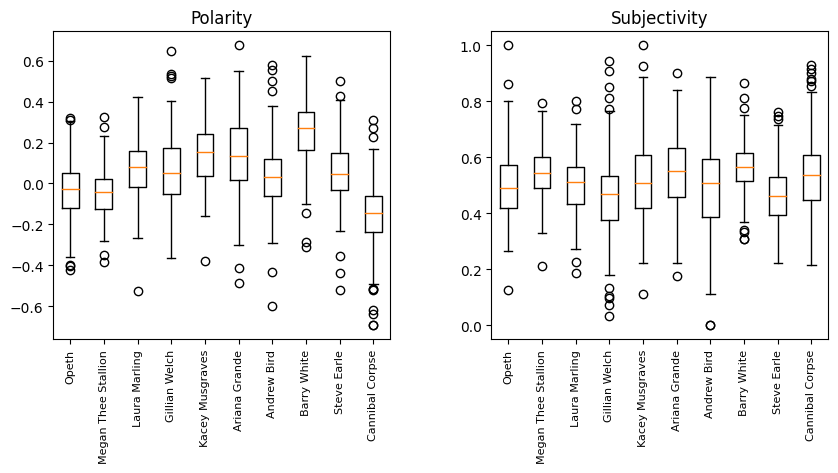

In [46]:
plot_box_graph(["Polarity", "Subjectivity"])

Now we want to add the TFIDF features. For this, we need to split our dataset into train and test, so we can compose documents with only the training points.

In [47]:
df = df.reset_index(drop=True)

artists = df['Artist'].unique()

train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['Artist'])

print(f'Training size : {train_df.shape[0]}')
print(f'Testing size : {test_df.shape[0]}')

Training size : 10758
Testing size : 1899


In [48]:
df.head()

Lyrics  Nb_Lines  Nb_Words  \
0  [[the, lord, is, my, shepherd, i, shall, not, ...        22       165   
1  [[you, look, good, out, there, babi], [i, wa, ...        54       373   
2  [[a, long, time, ha, come, and, gone], [i'v, s...        34       197   
3  [[a, lover', hideaway, yeah], [from, all, thi,...        23       160   
4  [[well, i'm, tri, lord, to, be, full, of, your...        28       212   

                                          Raw_Lyrics                   Title  \
0  \nThe lord is my shepherd I shall not want\nOh...              23rd psalm   
1  \nYou look good out there, baby\n\nI was born ...  a change is gonna come   
2  \nA long time has come and gone\nI've seen mor...             a long time   
3  \nA lover's hideaway, yeah\nFrom all this pain...      a lover's hideaway   
4  \nWell, I'm trying Lord, to be full of Your co...                   again   

   Artist  RID_EMOTIONS:AFFECTION  RID_SECONDARY:SOCIAL:BEHAVIOR  \
0       1                0.005952                       0.023810   
1       1                0.007634                       0.053435   
2       1                0.009615                       0.028846   
3       1                0.029240                       0.029240   
4       1                0.000000                       0.027027   

   RID_SECONDARY:ABSTRACTION  RID_SECONDARY:TEMPORAL:REFERENCES  ...  \
0                   0.011905                           0.011905  ...   
1                   0.030534                           0.027990  ...   
2                   0.019231                           0.043269  ...   
3                   0.000000                           0.023392  ...   
4                   0.022523                           0.081081  ...   

   CHUNK_PERSON  CHUNK_ORGANIZATION  CHUNK_LOCATION  CHUNK_FACILITY  \
0      0.012121            0.012121             0.0             0.0   
1      0.000000            0.000000             0.0             0.0   
2      0.005076            0.000000             0.0             0.0   
3      0.012500            0.006250             0.0             0.0   
4      0.009434            0.000000             0.0             0.0   

   CHUNK_GSP     Slang      Rare  Title_In_Song  Polarity  Subjectivity  
0        0.0  0.042424  0.751515          False  0.048148      0.492593  
1        0.0  0.008043  0.785523           True  0.108736      0.388803  
2        0.0  0.000000  0.817259           True  0.125000      0.436111  
3        0.0  0.000000  0.756250           True  0.098295      0.612500  
4        0.0  0.000000  0.792453           True  0.015000      0.612500  

[5 rows x 72 columns]

We compose the documents. One document has all the lyrics of 1 single artist.

In [49]:
documents = []
available_artists  = list(set(df['Artist'].to_list()))
for i in available_artists:
    d = train_df.loc[train_df['Artist'] == i, 'Lyrics'].tolist()
    d = [flatten(song) for song in d]
    d = flatten(d)
    documents.append(d)
    
    
documents = [' '.join(doc) for doc in documents]

df_docs_train = pd.DataFrame({"All_Lyrics" : documents, 
                        "Artist" : available_artists})

df_docs_train.head()

All_Lyrics  Artist
0  there' no way there' just no way i could leav ...       1
1  see her light how it reign so hard on your hig...       2
2  friend or foe there' no way to know in the bat...       3
3  open sesam we'v place to go we'v peopl to see ...       4
4  more than the greatest love the world ha known...       5

Get the TFIDF weights.

In [50]:
docs = df_docs_train["All_Lyrics"].to_list()

cv = CountVectorizer()
stem_count_vector = cv.fit_transform(docs)
#stem_count_vector = cv.fit_transform(documents)

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit_transform(stem_count_vector)

# Get the feature names and IDF weights
feature_names = cv.get_feature_names_out()
idf_weights = tfidf_transformer.idf_

df_words_weights = pd.DataFrame({'word': cv.get_feature_names_out(), 'weight': tfidf_transformer.idf_})
 
df_words_weights.sort_values('weight').head()

word  weight
27412     wa     1.0
1112      am     1.0
2506    been     1.0
23510  sound     1.0
27452   wait     1.0

In [51]:
df_words_weights.sort_values('weight', ascending=False).head()

word    weight
0           00  4.806662
16185   mohawk  4.806662
16195    molar  4.806662
16194      mok  4.806662
16192  moistur  4.806662

In [52]:
df_words_weights.shape[0]

28839

In [53]:
df.shape[0]

12657

In [54]:
def tdif_features(songs):
    
    song_features_list = []

    for i, song in enumerate(songs):

        # convert the song to a string
        song_text = ' '.join(song)

        # transform the song text to a count vector
        song_counts = cv.transform([song_text])

        # compute the TF-IDF features for the song
        song_features = tfidf_transformer.transform(song_counts)

        # convert the sparse matrix to a dataframe
        song_features_df = pd.DataFrame(song_features.toarray(), columns=feature_names)

        # append the song features to the list
        song_features_list.append(song_features_df)

    song_features_list = np.array(song_features_list)
    song_features_list = song_features_list.reshape((song_features_list.shape[0], song_features_list.shape[2]))
    df_tfidf = pd.DataFrame(song_features_list, columns=feature_names)
    df_tfidf['Artist'] = df['Artist'].to_list()
    
    return df_tfidf

In [55]:
df_tfidf = tdif_features(songs_flatten)

In [56]:
df_tfidf.shape

(12657, 28840)

In [57]:
valid_columns = df_tfidf.iloc[:, :-1].select_dtypes(include=np.number)
# calculate the sum of each row
sum_array = np.array(valid_columns.sum(axis=1))

# add the sum_array as a new column in the DataFrame
df["TF_IDF_Score"] = sum_array

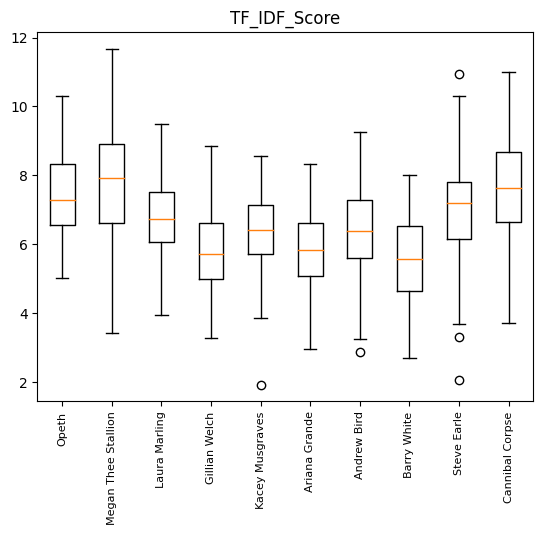

In [58]:
plot_box_graph(["TF_IDF_Score"])

Let us only keep the 1000 terms with the most weight.

In [59]:
to_keep = df_words_weights.iloc[:1000]["word"].tolist()

We have now a data frame where the features are the selected 1000 terms and each row is a song

In [60]:
df_tfidf_reduced = pd.concat([df_tfidf[column] for column in to_keep], axis=1)

# Display the new DataFrame
df_tfidf_reduced.head()

00  007  012   02   03   04   05   06   07   09  ...  aling  alisha  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   

   alison  alittl  aliv  alive  aliveal  aliz  alkalin       all  
0     0.0     0.0   0.0    0.0      0.0   0.0      0.0  0.000000  
1     0.0     0.0   0.0    0.0      0.0   0.0      0.0  0.044390  
2     0.0     0.0   0.0    0.0      0.0   0.0      0.0  0.081447  
3     0.0     0.0   0.0    0.0      0.0   0.0      0.0  0.191914  
4     0.0     0.0   0.0    0.0      0.0   0.0      0.0  0.048314  

[5 rows x 1000 columns]

We reduce the number of TFIDF features using a PCA.

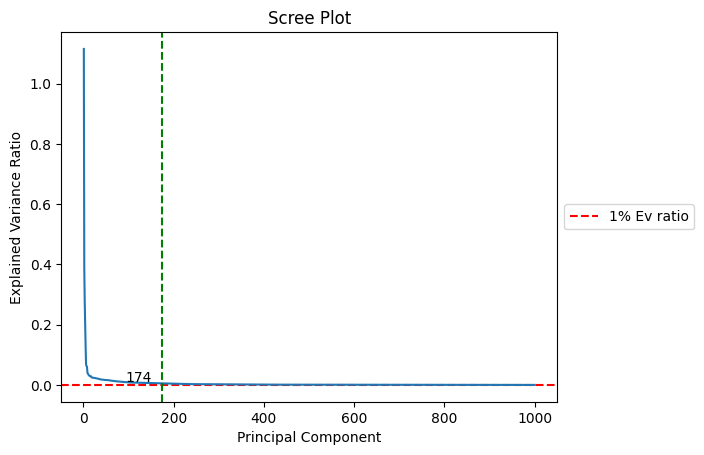

In [61]:
# Perform PCA
pca = PCA()
pca.fit(df_tfidf_reduced)
df_transformed = pca.transform(df_tfidf_reduced)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

plt.axhline(y=0.001, color='r', linestyle='--', label='1% Ev ratio')

# Create scree plot
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio*5, marker='', linestyle='-')

# Find the index of intersection
intersection_index = -1
for i in range(len(explained_variance_ratio)):
    if explained_variance_ratio[i] <= 0.001:
        intersection_index = i
        break

# Add a vertical line at the intersection point
plt.axvline(x=intersection_index + 1, color='g', linestyle='--')
plt.text(intersection_index - 50, 0.01, f'{intersection_index + 1}', ha='center')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot the index of intersection on the x-axis
plt.show()

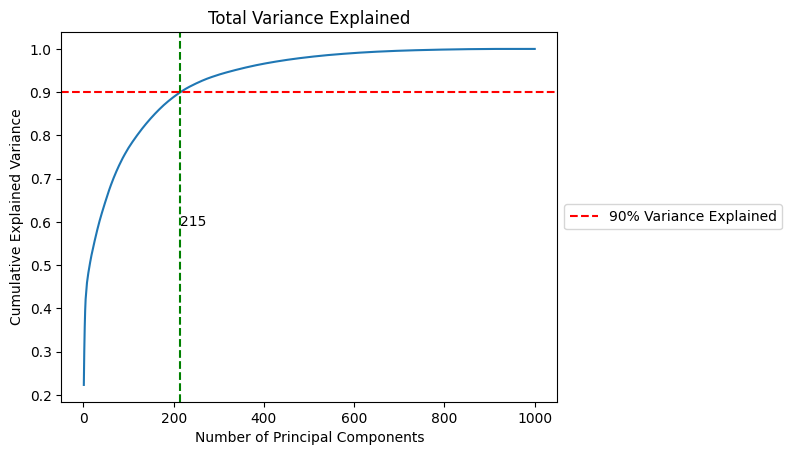

In [62]:
# Calculate cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
# Create total variance explained plot with a line
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Total Variance Explained')
# Add a line at 80% cumulative explained variance
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Explained')
plt.legend()
# Find the index where cumulative variance exceeds 90%
idx = next(x for x, value in enumerate(cumulative_variance) if value >= 0.9)
# Add a vertical line at the intersection point
plt.axvline(x=idx + 1, color='g', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot the index of intersection on the x-axis
plt.text(idx + 1, 0.6, f'{idx + 1}', ha='left', va='center')

plt.show()

We keep the 150 principal components.

In [63]:
n_comp = 150
pca = PCA(n_components=n_comp)
df_tfidf_pca = pca.fit_transform(df_tfidf_reduced)

df_filtered_pca = pd.DataFrame(df_tfidf_pca, columns=[f'PC{i}' for i in range(1, n_comp+1)])

df_filtered_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.042433 -0.010393 -0.008412 -0.006173 -0.002191 -0.001484 -0.000648   
1  0.002771 -0.009072 -0.009378  0.016097 -0.003569 -0.003333 -0.000962   
2  0.038980 -0.011448 -0.009125 -0.007605 -0.002174 -0.002501 -0.000497   
3  0.149400 -0.012880 -0.010092 -0.009547 -0.002152 -0.003879 -0.000292   
4  0.007122 -0.023660  0.136294 -0.006052 -0.001324 -0.002362 -0.000979   

        PC8       PC9      PC10  ...     PC141     PC142     PC143     PC144  \
0 -0.002058 -0.000243 -0.002170  ... -0.000139 -0.000131 -0.000218 -0.000140   
1 -0.000235 -0.000849 -0.001865  ...  0.000010 -0.000264  0.000040  0.000515   
2 -0.002021 -0.000232 -0.002208  ... -0.000185 -0.000131 -0.000181 -0.000217   
3 -0.001970 -0.000216 -0.002260  ... -0.000246 -0.000131 -0.000132 -0.000320   
4 -0.002585 -0.000709  0.000256  ...  0.000155  0.000401  0.000484 -0.000323   

      PC145     PC146     PC147     PC148     PC149     PC150  
0 -0.000249 -0.000048 -0.000018 -0.000078  0.000164 -0.000113  
1 -0.000008  0.000205  0.000027  0.000059 -0.000308 -0.000012  
2 -0.000207 -0.000033 -0.000009 -0.000022  0.000128 -0.000136  
3 -0.000150 -0.000013  0.000004  0.000055  0.000078 -0.000168  
4  0.000058 -0.000347 -0.000135 -0.000126 -0.001063  0.000055  

[5 rows x 150 columns]

In [64]:
#############
# new data frame containing all the numerical features
############
new_df = pd.concat([df.reset_index(drop=True), df_filtered_pca.reset_index(drop=True)], axis = 1)
new_df = new_df.reset_index(drop=True)
new_df.columns

Index(['Lyrics', 'Nb_Lines', 'Nb_Words', 'Raw_Lyrics', 'Title', 'Artist',
       'RID_EMOTIONS:AFFECTION', 'RID_SECONDARY:SOCIAL:BEHAVIOR',
       'RID_SECONDARY:ABSTRACTION', 'RID_SECONDARY:TEMPORAL:REFERENCES',
       ...
       'PC141', 'PC142', 'PC143', 'PC144', 'PC145', 'PC146', 'PC147', 'PC148',
       'PC149', 'PC150'],
      dtype='object', length=223)

Now we only keep the numerical features.

In [65]:
numerical_df = new_df.drop(['Artist', 'Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
numerical_df.head()

Nb_Lines  Nb_Words  RID_EMOTIONS:AFFECTION  RID_SECONDARY:SOCIAL:BEHAVIOR  \
0        22       165                0.005952                       0.023810   
1        54       373                0.007634                       0.053435   
2        34       197                0.009615                       0.028846   
3        23       160                0.029240                       0.029240   
4        28       212                0.000000                       0.027027   

   RID_SECONDARY:ABSTRACTION  RID_SECONDARY:TEMPORAL:REFERENCES  \
0                   0.011905                           0.011905   
1                   0.030534                           0.027990   
2                   0.019231                           0.043269   
3                   0.000000                           0.023392   
4                   0.022523                           0.081081   

   RID_SECONDARY:INSTRUMENTAL:BEHAVIOR  \
0                             0.011905   
1                             0.002545   
2                             0.004808   
3                             0.011696   
4                             0.018018   

   RID_PRIMARY:REGRESSIVE:COGNITION:NARCISSISM  RID_EMOTIONS:ANXIETY  \
0                                     0.005952              0.005952   
1                                     0.007634              0.002545   
2                                     0.004808              0.000000   
3                                     0.000000              0.000000   
4                                     0.000000              0.018018   

   RID_PRIMARY:SENSATION:VISION  ...     PC141     PC142     PC143     PC144  \
0                      0.005952  ... -0.000139 -0.000131 -0.000218 -0.000140   
1                      0.017812  ...  0.000010 -0.000264  0.000040  0.000515   
2                      0.019231  ... -0.000185 -0.000131 -0.000181 -0.000217   
3                      0.000000  ... -0.000246 -0.000131 -0.000132 -0.000320   
4                      0.000000  ...  0.000155  0.000401  0.000484 -0.000323   

      PC145     PC146     PC147     PC148     PC149     PC150  
0 -0.000249 -0.000048 -0.000018 -0.000078  0.000164 -0.000113  
1 -0.000008  0.000205  0.000027  0.000059 -0.000308 -0.000012  
2 -0.000207 -0.000033 -0.000009 -0.000022  0.000128 -0.000136  
3 -0.000150 -0.000013  0.000004  0.000055  0.000078 -0.000168  
4  0.000058 -0.000347 -0.000135 -0.000126 -0.001063  0.000055  

[5 rows x 219 columns]

We are gojng to visualize the data in a PCA plot, so we choose again a sample of 10 artists to plot. The line can be re-run multiple times to get a more interesting sample.

In [66]:
if NUMBER_OF_ARTISTS > 10:
    sample = random.sample(list(arts_dict_op.keys()), 10)
else:
    sample = random.sample(list(arts_dict_op.keys()), NUMBER_OF_ARTISTS)

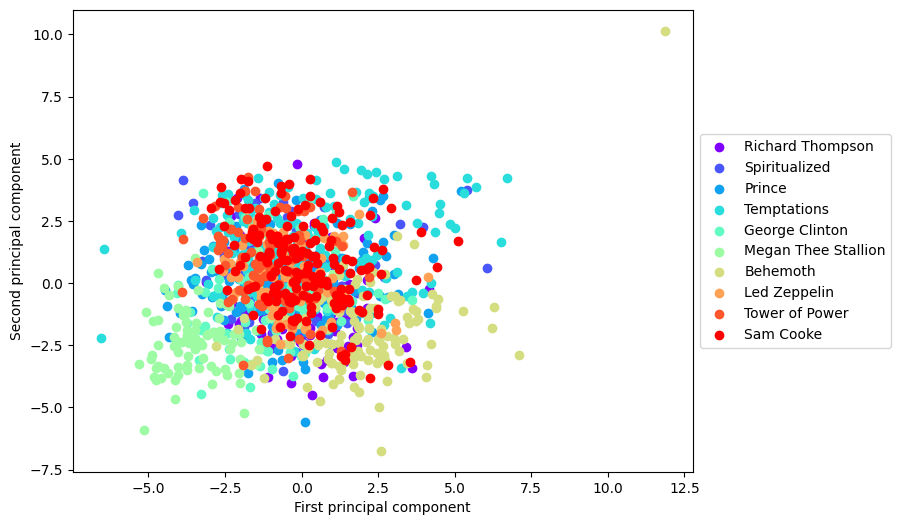

In [67]:
y = new_df["Artist"].to_list()
y = np.array([int(yy) for yy in y])


scaler = StandardScaler()
numerical_df_scaled = scaler.fit_transform(numerical_df)

pca = PCA(n_components=2).fit(numerical_df_scaled)
data2D = pca.transform(numerical_df_scaled)

artist_labels = [arts_dict_op[i] for i in sample]

# Create separate scatter plots for each unique label
colors = plt.cm.rainbow(np.linspace(0, 1, len(sample)))  # Generate a range of colors

fig, ax = plt.subplots(figsize=(8, 6))

for label, art, color in zip(sample, artist_labels, colors):
    mask = (y == label)
    scatter = ax.scatter(data2D[:, 0][mask], data2D[:, 1][mask], c=[color], label=art)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')

# Save the plot as an image
#save_path = os.path.join(save_dir, 'PCA_all_feat_2.png')
#plt.savefig(save_path, bbox_inches='tight', bbox_extra_artists=[ax.legend_])

plt.show()

Now, let us plot random pairs of artists.

In [68]:
scaler = StandardScaler()
numerical_df_scaled = scaler.fit_transform(numerical_df)

pca = PCA(n_components=2).fit(numerical_df_scaled)
data2D = pca.transform(numerical_df_scaled)

combinations = list(itertools.combinations(arts_dict_op.keys(), 2))
random.shuffle(combinations)
sampled_indices = combinations[:4]
artist_labels_list = [[arts_dict_op[i] for i in indices] for indices in sampled_indices]


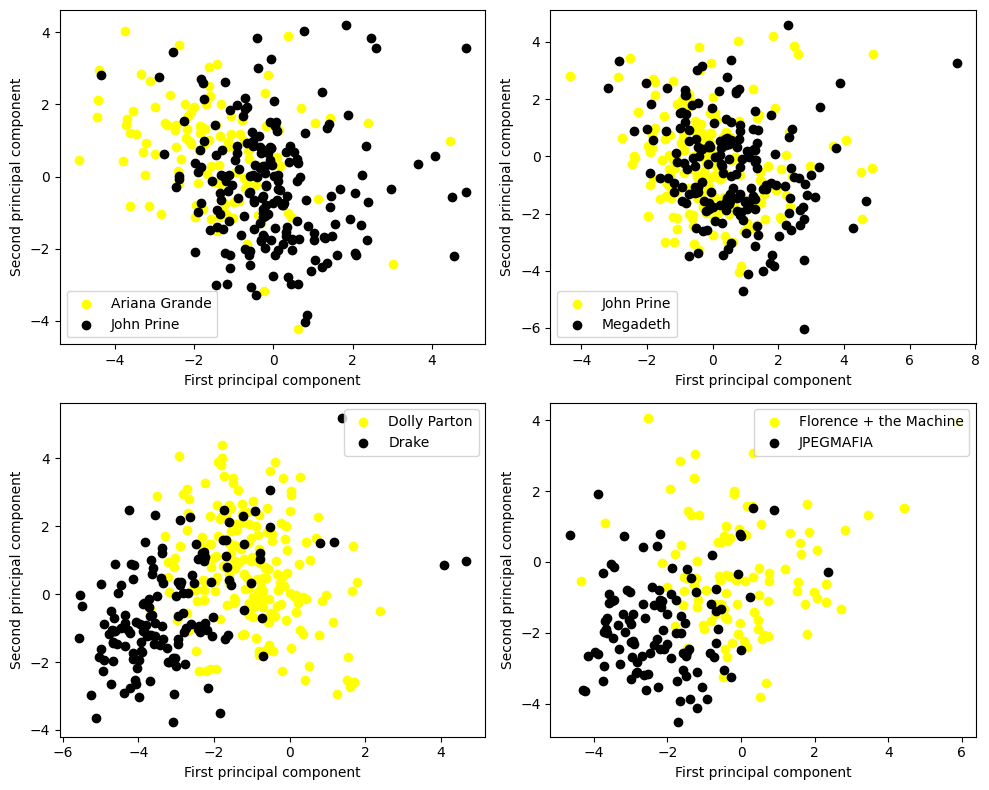

In [69]:
# yellow for artist 1 and black for artist 2
colors_list = ['yellow', 'black']

plt.figure(figsize=(10, 8))

for i, indices in enumerate(sampled_indices):
    plt.subplot(2, 2, i + 1)
    for j, label in enumerate(indices):
        mask = (y == label)
        color = colors_list[j % 2]  # alternate between yellow and black
        scatter = plt.scatter(data2D[:, 0][mask], data2D[:, 1][mask], c=color, label=artist_labels_list[i][j])
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.legend()
    #save_path = os.path.join(save_dir, f'plot_2arts_PCA2_second.png')
    #plt.savefig(save_path)

plt.tight_layout()
plt.show()

We group all the TF-IDF features as entries of a TF-IDF vector.

In [70]:
def create_tfidfvector(df):
    if 'TFIDF_Vector' in df.columns:
        df.drop('TFIDF_Vector', inplace=True, axis=1)

    pca_arrays = []
    for index, row in df.iterrows():
        pca_columns = row[df.columns.str.startswith('PC')].values
        pca_arrays.append(np.array(pca_columns))

    df['TFIDF_Vector'] = pca_arrays

create_tfidfvector(new_df)

In [71]:
train_indices = train_df.index
test_indices = test_df.index
train_df = new_df.iloc[train_indices]
test_df = new_df.iloc[test_indices]
('TFIDF_Vector' in train_df.columns)
('Lines_similarity' in train_df.columns)

True

# GET THE TESTING DATA

In [78]:
num_train = train_df.drop(['Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
num_test = test_df.drop(['Lyrics', 'Title', 'Raw_Lyrics'], axis=1)

# LOGISTIC REGRESSION STARTS

In [86]:
def n_sets_func(nsets): 
    artists_set = random.sample(list(arts_dict_op.keys()), nsets)
    pos_w = (nsets-1)/nsets
    neg_w = 1/nsets
    return artists_set, pos_w, neg_w


In [87]:
def n_sets_func_mine(df, art_set):    
    df2 = df.drop(df.columns[[0, 3, 4]], axis=1)
    df2.reset_index(drop=True, inplace=True)
    df2 = df2[df2['Artist'].isin(art_set)]
    n_art = len(art_set)
    pos_w = (n_art-1)/n_art
    neg_w = 1/n_art
    fts = df2.columns
    return df2, fts, pos_w, neg_w

In [88]:
def mean_of_arrays(matrix):
    mean_values = np.mean(matrix, axis=0)
    return mean_values.tolist()

In [89]:
def artist_df(artist, df):
    """
    takes the artist number and the training dataframe
    returns the mean and std devaition for all somgs of that artist in that dataframe
    """
    
    art_data = df[df['Artist'] == artist]
    arrays = art_data['TFIDF_Vector'].values
    
    #convert the arrays into a matrix
    matrix = np.stack(arrays)
    mean = np.array(mean_of_arrays(matrix))
    # calculate the average features 
    average_features_artist = art_data.mean(numeric_only=True)
    # Calculate the standard deviation of features 
    std_features_artist = art_data.std(numeric_only=True)
    k= ((pd.DataFrame({'Average': average_features_artist, 'Standard Deviation': std_features_artist})).transpose()).drop("Artist", axis=1)
    return k,mean


In [90]:
def cosine_angle(vector1, vector2):
    """
    Similarity between 2 vectors between 0 and 1. To be used for PCAd TFIDF components.
    """
    dot_prod = np.dot(vector1, vector2)
    mag1 = np.linalg.norm(vector1)
    mag2 = np.linalg.norm(vector2)
    if(mag1 *mag2 !=0):
        return dot_prod / (mag1 * mag2)
    return 0
    

In [91]:
def std_rows(df):
    """
    Takes a dataframe with the first 2 rows belonging to an artist and the following rows representing songs.
    Returns the dataframe to be trained for that artist.
    """
    art_pca = df.iloc[0, -1]

    for i in range(2, len(df)):
        df.iloc[i, -1] = cosine_angle(art_pca, df.iloc[i, -1])

    first_row = df.iloc[0, :-1]
    s_row = df.iloc[1, :-1]

    mask = s_row != 0  # Create a mask to avoid division by zero
    df.iloc[2:, :-1] = (first_row - df.iloc[2:, :-1]) / np.where(mask, s_row, 1)

    df = df.iloc[2:].reset_index(drop=True)
    return df


In [92]:
#### Will make the dataframe of songs for any artist
def df_maker(artist, df, df2):
    """ 
    INPUTS
    artist- aritst number, int
    df- dataframe with songs and their features
    output- dataframe with featurs of the song wrt the aritst
    """
    art_df, meanpca = artist_df(artist, df2)
    art_df["TFIDF_Vector"] = [meanpca, None]
    comb_df = pd.concat([art_df, df])
    return (std_rows(comb_df))

In [93]:
def top_K_accs(y_test, arr):
    
    y_test = np.array(y_test)
    l = len(y_test)
    top_accs=[]
    for max_indices in arr:
        s=0
        for i in range(0,l):
            if y_test[i] in max_indices[i]:
                s+=1
        top_accs.append(100*s/l)
    return(top_accs)

In [94]:
def logistic_test(artists_set, top, x_train, x_test):

    df2, _, pos_w, neg_w = n_sets_func_mine(df=x_train, art_set = artists_set)
    x_train = df2.drop('Artist', axis=1)
    y_train = df2['Artist']

    
    df3, _, pos_w, neg_w = n_sets_func_mine(df=x_test, art_set = artists_set)
    x_test = df3.drop('Artist', axis=1)
    y_test = df3['Artist']
    fts = x_train.columns
    
    probs =[]
    coeffs=[]

    for i in artists_set:
        X2 = df_maker(artist = i,df = x_train, df2= df2)
        X2 = pd.concat([X2.reset_index(drop=True), x_train.iloc[:,:-1].reset_index(drop=True)], axis=1)
        X3 = (df_maker(artist =i,df = x_test, df2=df2))
        X3 = pd.concat([X3.reset_index(drop=True), x_test.iloc[:, :-1].reset_index(drop=True)], axis =1)
        y2 = np.array([1 if x == i else 0 for x in y_train])
        # Split the data into training and testing sets
        logreg = LogisticRegression(max_iter=5000, solver='lbfgs', class_weight={0: neg_w, 1: pos_w})
        logreg.fit(X2, y2)
        coefficients = logreg.coef_
        coeffs.append(coefficients[0])
        probs.append(logreg.predict_proba(X3)[:, 1])
    coeffs = np.vstack(coeffs)
    coeffs= np.mean(coeffs, axis=0)
    probs = np.array(probs)
    probs_by_tops=[]
    for i in top:
        Q = (np.argsort(probs, axis=0)[-i:, :]).transpose()
        temp = []
        for i in Q:
            temp2=[]
            for j in i:
                temp2.append(artists_set[j])
            temp.append(temp2)
        probs_by_tops.append(temp)
    return probs_by_tops, top_K_accs(y_test=y_test,arr= probs_by_tops), coeffs, y_test, fts, artists_set

In [95]:
def logistic_train_acc(artists_set, top, x_train):

    df2, _, pos_w, neg_w = n_sets_func_mine(df=x_train, art_set = artists_set)
    x_train = df2.drop('Artist', axis=1)
    y_train = df2['Artist']

    probs =[]

    for i in artists_set:
        X2 = df_maker(artist = i,df = x_train, df2= df2)
        X2 = pd.concat([X2.reset_index(drop=True), x_train.iloc[:,:-1].reset_index(drop=True)], axis=1)
        y2 = np.array([1 if x == i else 0 for x in y_train])
        # Split the data into training and testing sets
        logreg = LogisticRegression(max_iter=5000, solver='lbfgs', class_weight={0: neg_w, 1: pos_w})
        logreg.fit(X2, y2)
        probs.append(logreg.predict_proba(X2)[:, 1])
    probs = np.array(probs)
    probs_by_tops=[]
    for i in top:
        Q = (np.argsort(probs, axis=0)[-i:, :]).transpose()
        temp = []
        for i in Q:
            temp2=[]
            for j in i:
                temp2.append(artists_set[j])
            temp.append(temp2)
        probs_by_tops.append(temp)
    return top_K_accs(y_test=y_train,arr= probs_by_tops)

In [96]:
def logistic_test_random_bagging(artists_set, top, x_train, x_test, nest, max_sam, max_fts, oob, warm):

    df2, _, pos_w, neg_w = n_sets_func_mine(df=x_train, art_set = artists_set)
    x_train = df2.drop('Artist', axis=1)
    y_train = df2['Artist']

    df3, _, pos_w, neg_w = n_sets_func_mine(df=x_test, art_set = artists_set)
    x_test = df3.drop('Artist', axis=1)
    y_test = df3['Artist']
    fts = x_train.columns
    
    probs =[]

    for i in artists_set:
        X2 = df_maker(artist = i,df = x_train, df2= df2)
        X2 = pd.concat([X2.reset_index(drop=True), x_train.iloc[:,:-1].reset_index(drop=True)], axis=1)
        X3 = (df_maker(artist =i,df = x_test, df2=df2))
        X3 = pd.concat([X3.reset_index(drop=True), x_test.iloc[:, :-1].reset_index(drop=True)], axis =1)
        y2 = np.array([1 if x == i else 0 for x in y_train])
        # Split the data into training and testing sets
        logreg = LogisticRegression(max_iter=8000, solver='lbfgs', class_weight={0: neg_w, 1: pos_w})
        logreg_bagging = BaggingClassifier(estimator=logreg, n_estimators=nest, max_samples=max_sam, max_features=max_fts, oob_score = oob, warm_start=warm)
        logreg_bagging.fit(X2, y2)
        probs.append(logreg_bagging.predict_proba(X3)[:, 1])
    probs = np.array(probs)
    probs_by_tops=[]
    for i in top:
        Q = (np.argsort(probs, axis=0)[-i:, :]).transpose()
        temp = []
        for i in Q:
            temp2=[]
            for j in i:
                temp2.append(artists_set[j])
            temp.append(temp2)
        probs_by_tops.append(temp)
    return  top_K_accs(y_test=y_test,arr= probs_by_tops)

In [97]:
def logistic_test_random_boosting(artists_set, top, x_train, x_test):
    

    df2, _, pos_w, neg_w = n_sets_func_mine(df=x_train, art_set = artists_set)
    x_train = df2.drop('Artist', axis=1)
    y_train = df2['Artist']

    df3, _, pos_w, neg_w = n_sets_func_mine(df=x_test, art_set = artists_set)
    x_test = df3.drop('Artist', axis=1)
    y_test = df3['Artist']
    
    probs =[]

    for i in artists_set:
        X2 = df_maker(artist = i,df = x_train, df2= df2)
        X2 = pd.concat([X2.reset_index(drop=True), x_train.iloc[:,:-1].reset_index(drop=True)], axis=1)
        X3 = (df_maker(artist =i,df = x_test, df2=df2))
        X3 = pd.concat([X3.reset_index(drop=True), x_test.iloc[:, :-1].reset_index(drop=True)], axis =1)
        y2 = np.array([1 if x == i else 0 for x in y_train])
        # Split the data into training and testing sets
        adaboost = AdaBoostClassifier(estimator=LogisticRegression(max_iter=5000),n_estimators=50, learning_rate=1)
        adaboost.fit(X2, y2)
        probs.append(adaboost.predict_proba(X3)[:, 1])
    probs = np.array(probs)
    probs_by_tops=[]
    for i in top:
        Q = (np.argsort(probs, axis=0)[-i:, :]).transpose()
        temp = []
        for i in Q:
            temp2=[]
            for j in i:
                temp2.append(artists_set[j])
            temp.append(temp2)
        probs_by_tops.append(temp)
    return  top_K_accs(y_test=y_test,arr= probs_by_tops)

In [98]:
def misclassy(n, k, l):
    
    # n : number of artists considered
    # k : top k predictions considered
    # l : top l misclassified

    #Returns:
    #list: the top l most misclassified artist numbers by percentage.
    #list: the top l least misclassified artist numbers by percentage.
    
    misclassified_numbers = Counter()
    artists_set = random.sample(list(arts_dict_op.keys()), n)
    probs_by_tops, accs, _, y_test, _, artists_set = logistic_test(artists_set, top = [k], x_train = num_train,x_test= num_test)

    probs_by_tops = probs_by_tops[0]
    for i, true_value in enumerate(y_test):
        if true_value not in probs_by_tops[i]:
            misclassified_numbers[true_value] += 1

    total_samples = Counter(y_test)  # Count occurrences of each number in y_test

    misclassification_percentages = {
        number: count / total_samples[number] * 100
        for number, count in misclassified_numbers.items()
    }

    least_misclassified = sorted(
        misclassification_percentages.items(), key=lambda x: x[1]
    )[:l]
    
    top_misclassified = sorted(
        misclassification_percentages.items(), key=lambda x: x[1], reverse=True
    )[:l]

    print(f"The top {l} most misclassified numbers by percentage are:\n")
    for number, percentage in top_misclassified:
        print(f"Number: {arts_dict_op[number]}, Misclassification percentage: {percentage:.2f}%")
        
    print(f"The top {l} least misclassified numbers by percentage are:\n")
    for number, percentage in least_misclassified:
        print(f"Number: {arts_dict_op[number]}, Misclassification percentage: {percentage:.2f}%")
        
    return [top[0] for top in top_misclassified], [top[0] for top in least_misclassified]

In [99]:
def get_misclassified_top_n(y_test, probs, n):
    misclassified = []
    
    # Iterate over the predictions and true values
    for true_val, pred_val in zip(y_test, probs):
        if true_val != pred_val:
            misclassified.append(pred_val)
    
    # Count the occurrences of misclassified values
    vote_counts = Counter(misclassified)
    
    # Get the top n misclassified values with the most votes
    top_n_misclassified = vote_counts.most_common(n)
    
    return top_n_misclassified


In [101]:
#top, l_top = misclassy(n = 60, k = 8, l = 5)

In [ ]:
##top1, l_top1 = misclassy(n = 60, k = 8, l = 5)

In [ ]:
#top2, l_top2 = misclassy(n = 60, k = 8, l = 5)

In [ ]:
#all_mis = set(top + top1 + top2)
#all_least_mis = set(l_top + l_top1 + l_top2)

In [ ]:
#df_mis = new_df[new_df['Artist'].isin(all_mis|all_least_mis)]

In [ ]:
#df_mis = df_mis.drop(["Lyrics", "Raw_Lyrics", "TFIDF_Vector", "Title"], axis = 1)

In [ ]:
#df_mis['Mis'] = df_mis['Artist'].isin(all_mis)

In [ ]:
#df_mis.head()

In [ ]:
#df_mis_wart = df_mis.drop('Artist', axis=1)

In [ ]:
#scaler = StandardScaler()
#df_mis_wart = pd.DataFrame(scaler.fit_transform(df_mis_wart), columns=df_mis_wart.columns)

In [ ]:
# Group the DataFrame by the 'Mis' column and calculate the mean for each feature
#feature_means = df_mis_wart.groupby('Mis').mean()

# Calculate the absolute difference between the mean values of each feature for the two misclassification classes
#feature_diff = feature_means.diff().abs()

# Sort the features based on the absolute difference in descending order
#sorted_features = feature_diff.iloc[-1].sort_values(ascending=False)

In [ ]:
#top_10_features = sorted_features.head(10)

# Plot the top 10 features in a bar plot
#plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size
#top_10_features.plot(kind='bar', color='gray')
#plt.ylabel('Absolute Difference')
#plt.title('Top 10 features that change the most between well and baldy classified classes')
#plt.xticks(rotation='vertical')
#plt.show()

In [ ]:
#artists_of_interest = new_df[new_df['Artist'].isin(all_mis)]

# Count the number of songs per artist for the artists of interest
#counts_mis = artists_of_interest['Artist'].value_counts()

# Count the number of songs per artist for the other artists
#other_artists = new_df[~new_df['Artist'].isin(all_mis)]
#counts_other_artists = other_artists['Artist'].value_counts()

In [ ]:
#to_plot = [counts_mis.to_list(),counts_other_artists.to_list()]
#plt.boxplot(to_plot)
#xtick_labels = ['Badly classfied artists', 'Well classified artists']
#plt.gca().set_xticklabels(xtick_labels)
#save_path = os.path.join(save_dir, f'plot_size_diff_mis.png')
#plt.ylabel("Number of songs per artist")
#plt.savefig(save_path)
#plt.show()

In [ ]:
#numerical_df_scaled = pd.DataFrame(numerical_df_scaled, columns = numerical_df.columns)

In [ ]:
#numerical_df_scaled.head()

In [ ]:
#numerical_df_scaled = numerical_df_scaled.reset_index(drop=True)
#new_df = new_df.reset_index(drop=True)
#numerical_df_scaled['Artist'] = new_df['Artist'].copy()
#columns_to_drop = [col for col in df_mis_wart.columns if col.startswith('PC')]
#numerical_df_scaled = numerical_df_scaled.drop(columns=columns_to_drop)
#numerical_df_scaled.head()

In [ ]:
#av_songs = int(new_df['Artist'].value_counts().mean())
#print(f'The median number of songs per artist is {av_songs}')

# Get artists with more songs than the median
#artists_more_than_median = new_df['Artist'].value_counts()[new_df['Artist'].value_counts() > av_songs].index.tolist()

# Get artists with fewer songs than the median
#artists_less_than_median = new_df['Artist'].value_counts()[new_df['Artist'].value_counts() < av_songs].index.tolist()

In [ ]:
# variance_dict = {}  # Dictionary to store feature families and their variances

# for feature in numerical_df_scaled.columns:
#     if feature[:2] in {"Ar", "Mi"}:
#         continue
#     if feature[:2] == "PO":
#         family = "POS feat"
#     elif feature[:2] == "CH":
#         family = "CHUNK feat"
#     elif feature[:2] == "RI":
#         family = "RID feat"
#     else:
#         family = feature
        
#     feat_var_less = []
#     feat_var_more = []
    
#     for art in artists_more_than_median:
#         feat = numerical_df_scaled.loc[numerical_df_scaled['Artist'] == art, feature]
#         var = feat.var()
#         feat_var_less.append(var)
    
#     for art in artists_less_than_median :
#         feat = numerical_df_scaled.loc[numerical_df_scaled['Artist'] == art, feature]
#         var = feat.var()
#         feat_var_more.append(var)
    
#     if family in variance_dict:
#         variance_dict[family]['less_med'].extend(feat_var_less)
#         variance_dict[family]['more_med'].extend(feat_var_more)
#     else:
#         variance_dict[family] = {'less_med': feat_var_less, 'more_med': feat_var_more}

# # Calculate the mean variance for each feature family
# mean_variances_mis = []
# mean_variances_least_mis = []
# family_labels = []

# for family, variances in variance_dict.items():
#     mean_var_mis = np.mean(variances['less_med'])
#     mean_var_least_mis = np.mean(variances['more_med'])
#     mean_variances_mis.append(mean_var_mis)
#     mean_variances_least_mis.append(mean_var_least_mis)
#     family_labels.append(family)

# # Define the X_axis variable
# X_axis = np.arange(len(family_labels))

# # Plot the mean variances for the feature families
# plt.bar(X_axis, mean_variances_mis, 0.4, label='Less songs than avreage', color = "grey")
# plt.bar(X_axis + 0.4, mean_variances_least_mis, 0.4, label='More songs than avreage', color = "yellow")

# plt.xticks(X_axis, family_labels, rotation=45, ha='right')
# plt.title('Mean Variance for Feature Families per artist')
# plt.legend()
# plt.show()

warm = true has given better results than false in every comparison conducted

In [102]:
# Plot each array of y values
def plot_top_tog(brr, nlist, top):
    brr2 = brr

    max_len = max(len(sublist) for sublist in brr2)
    drr = [[] for _ in range(max_len)]

    for sublist in brr2:
        for i, element in enumerate(sublist):
            drr[i].append(element)

    brr2=drr

    counter=0
    for y_values in brr2:
        plt.plot(nlist[-len(y_values):], y_values, marker='o', label = "top "+str(top[counter])+" choices")
        counter+=1

    # Add labels and title
    plt.xlabel('Number of aritsts')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of n artists with top k choices')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.show()

    save_path = os.path.join(save_dir, f'top_k_together_test.png')        
    plt.savefig(save_path, bbox_inches='tight')

In [103]:
def process_data(data, st, name):
    features = data['feature']
    coefficients = data[name]
    
    new_features = []
    new_coefficients = []
    pos_coefficients = []
    pos_total = 0.0
    
    for feature, coefficient in zip(features, coefficients):
        if feature.startswith(st):
            pos_coefficients.append(coefficient)
        else:
            new_features.append(feature)
            new_coefficients.append(coefficient)
    
    if pos_coefficients:
        pos_total = sum(pos_coefficients)
        real = st
        if(st == 'PC' or st =='TF'):
            real = "TF IDF Feat"
        elif(st=='Nb'):
            real = "shape Feat"
        elif(st == 'RI'):
            real = 'RID Feat'
        elif(st == 'PO'):
            real = 'POS Feat'
        elif(st=="Su"):
            real= 'Subjectivity'
        elif(st == 'Po'):
            real = 'Polarity'
        elif(st=='TT'):
            real = 'TTR'
        elif(st == 'Sl'):
            real = 'Slang'
        elif(st=='Ra'):
            real = "Rare"
        elif(st=='Li'):
            real = "Line similarity"
        elif(st=="CH"):
            real = 'Chunk Feat'
        elif(st=='Ti'):
            real = 'Title in Song'
        new_features.append(real)
        new_coefficients.append(pos_total)
    
    processed_data = {
        'feature': new_features,
        name: new_coefficients
    }
    
    return processed_data

In [104]:
def plotter(data, name, b, c):
    feature_importance_df = pd.DataFrame(data)
    sorted_df = feature_importance_df.sort_values(name)
    if b:
        plt.figure(figsize=(12, 6))  # Set the figure size to be wider (12 units wide, 6 units tall)
        x_label_fontsize = 8  # Set the font size for x-axis labels
    else:
        plt.figure()  # Use default figure size
        x_label_fontsize = 12  # Set the font size for x-axis labels
    
    plt.bar(sorted_df['feature'], sorted_df[name], facecolor='gray', align='center')
    plt.xlabel('Feature', fontsize=x_label_fontsize)  # Set the x-axis label font size
    plt.ylabel(name)  # Reduce the y-axis label size
    if(c==3):
        plt.title(f'Importance Percentage in the classification of the features')  # Reduce the title size
    if(c==2):
        plt.title(f'Importance in the classification of the features (absolute value normalised)')
    if(c==1):
        plt.title(f'Coefficients in the classification of the features')
    plt.xticks(rotation=60, ha='right', fontsize=8)  # Rotate x-axis labels by 60 degrees, align right, and set the font size
    plt.yticks(fontsize=8)  # Reduce the y-axis tick label size
    plt.show()
    save_dir = os.getcwd()  # Assuming you want to save the file in the current working directory
    save_path = os.path.join(save_dir, 'ft_importance_test.png')
    plt.savefig(save_path, bbox_inches='tight')



In [107]:
def feature_imp1(crr, fts):    
    for coeffs in crr:
        fts2 = [(element+"_DN") for element in fts if element != 'Artist']
        for i in range(0,len(fts2)):
            if(fts2[i] == "PCA diff normal"):
                fts2[i] = "TF_IDF vector similarity"
        fts3 = [element for element in fts if element != 'Artist' and element !='PCA']
        fts2+=fts3
        print(len(fts2))
        fts4=[]
        coeffs2=[]
        for i in range(0,len(coeffs)):
            if(np.abs(coeffs[i])>=0.05):
                coeffs2.append(coeffs[i])
                fts4.append(fts2[i])
        data = {'feature': fts4, 'coefficient': coeffs2}
        plotter(data, 'coefficient', True,1)



def feature_imp2(crr, fts):    
    for coeffs in crr:
        fts2 = [(element+" diff normal") for element in fts if element != 'Artist']
        fts3 = [element for element in fts if element != 'Artist' and element !='PCA']
        fts2+=fts3
        coeffs2 = np.absolute(coeffs)
        coeffs2 = coeffs2/np.linalg.norm(coeffs2)
        indices=[]
        for i in range(0,len(fts2)):
            if (fts2[i].startswith('Ly')):
                indices.append(i)
        result = [x for i, x in enumerate(fts2) if i not in indices]
        res = [x for i, x in enumerate(coeffs2) if i not in indices]
        data = {'feature': result, 'coefficient': res}

        for bruh in fts3:
            data = process_data(data, bruh[:2], 'coefficient')
        plotter(data, 'coefficient', False,2)

def feature_imp3(crr, fts):    
    for coeffs in crr:
        fts2 = [(element+" diff normal") for element in fts if element != 'Artist']
        fts3 = [element for element in fts if element != 'Artist' and element !='PCA']
        fts2+=fts3
        coeffs2 = np.absolute(coeffs)
        coeffs2 = coeffs2/np.linalg.norm(coeffs2)
        coeffs3 = 100*coeffs2/np.sum(coeffs2)
        indices=[]
        for i in range(0,len(fts2)):
            if (fts2[i].startswith('Ly')):
                indices.append(i)
        result = [x for i, x in enumerate(fts2) if i not in indices]
        res = [x for i, x in enumerate(coeffs3) if i not in indices]
        data = {'feature': result, 'Percentage': res}
        for bruh in fts3:
            if(bruh.startswith('Ly')):
                continue
            data = process_data(data, bruh[:2], 'Percentage')
        plotter(data, 'Percentage', False,3)

In [ ]:
nlist=[128]
brr=[]
brrlog=[]
crr=[]
top=[]
fts = np.array(new_df.columns)
for n in nlist:
    maxbr=[0]
    maxcr=0
    maxbrlog=[0]
    top =[2**i for i in range(0, (int)(np.log2(n//2)+1))]
    for i in range(0,1):
        aset =  random.sample(list(arts_dict_op.keys()), n) 
        _,br,cr,_,_,_ = logistic_test(artists_set=aset,top=top, x_train = num_train, x_test = num_test)
        if(br[0]>maxbr[0]):
            maxbr = br
            maxcr = cr
        a = logistic_test_random_bagging(artists_set=aset, top = top, nest=10, x_train = num_train, x_test = num_test, max_sam = 1.0, max_fts = 1.0, oob = False, warm = True)
        print(a)
        if(a[0]>maxbrlog[0]):
            maxbrlog = a
    brr.append(maxbr)
    crr.append(maxcr)
    brrlog.append(maxbrlog)

In [ ]:
brrsave = brr
crrsave = crr
brrlogsave = brrlog

topsave = [1,2,4,8,16,32]
bs2 = brrsave
cs2 = crrsave
bls2 = brrlogsave
ts2 = topsave

brrsave = bs2
crrsave = cs2
brrlogsave = bls2
topsave = ts2

In [ ]:
variance_dict = {}  # Dictionary to store feature families and their variances

for feature in numerical_df_scaled.columns:
    if feature[:2] in {"Ar", "Mi"}:
        continue
    if feature[:2] == "PO":
        family = "POS feat"
    elif feature[:2] == "CH":
        family = "CHUNK feat"
    elif feature[:2] == "RI":
        family = "RID feat"
    else:
        family = feature

446


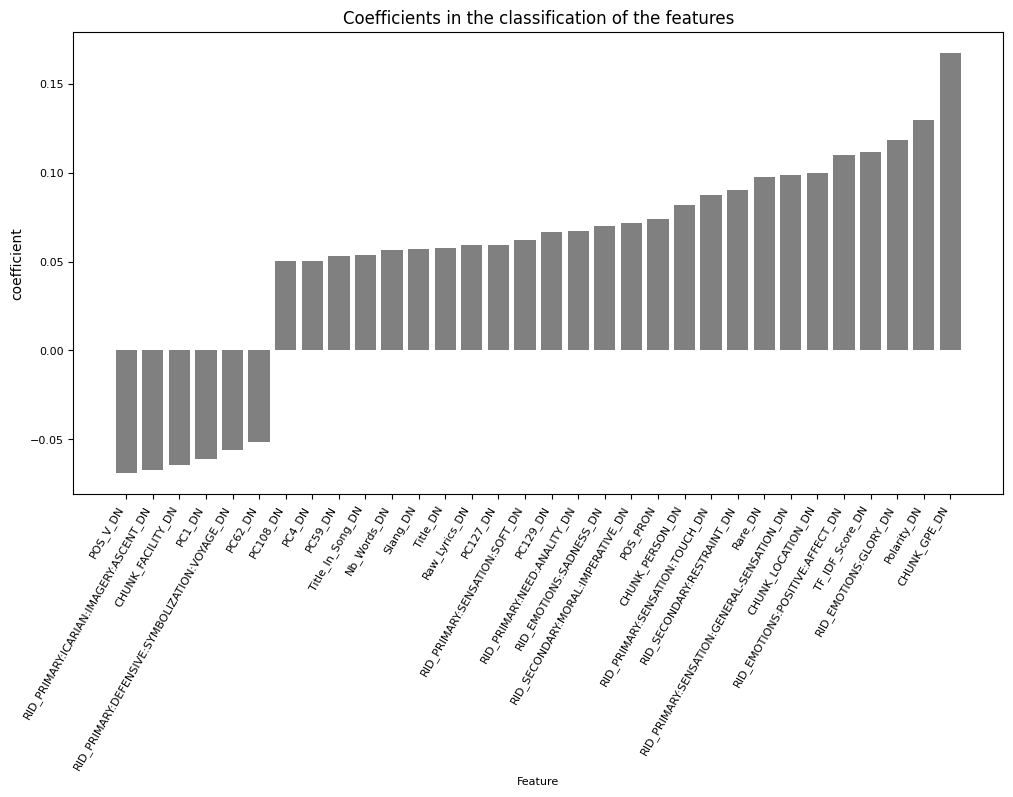

446


<Figure size 640x480 with 0 Axes>

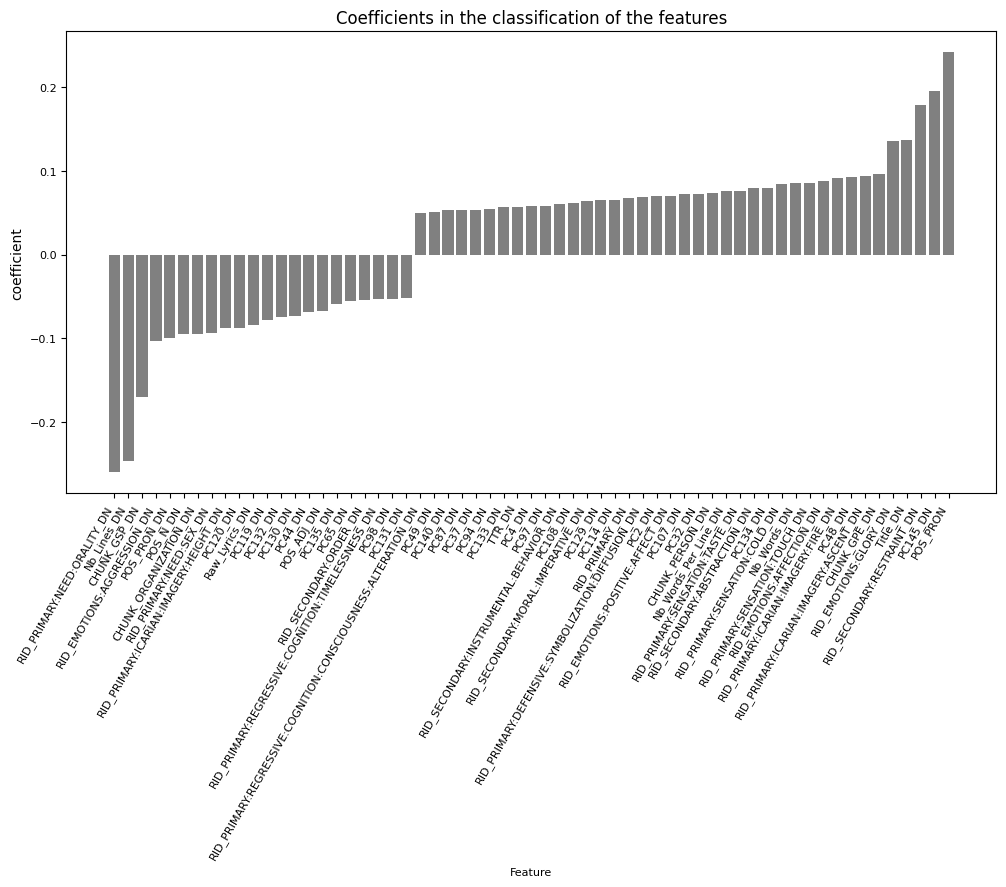

446


<Figure size 640x480 with 0 Axes>

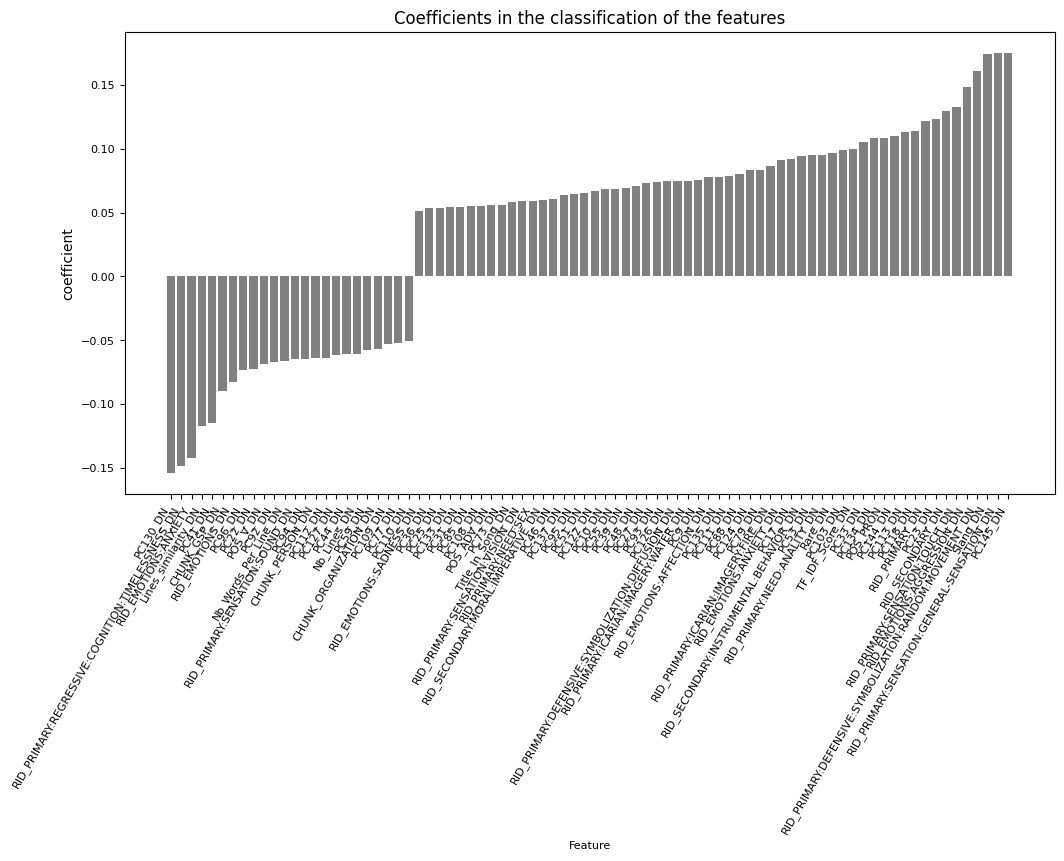

446


<Figure size 640x480 with 0 Axes>

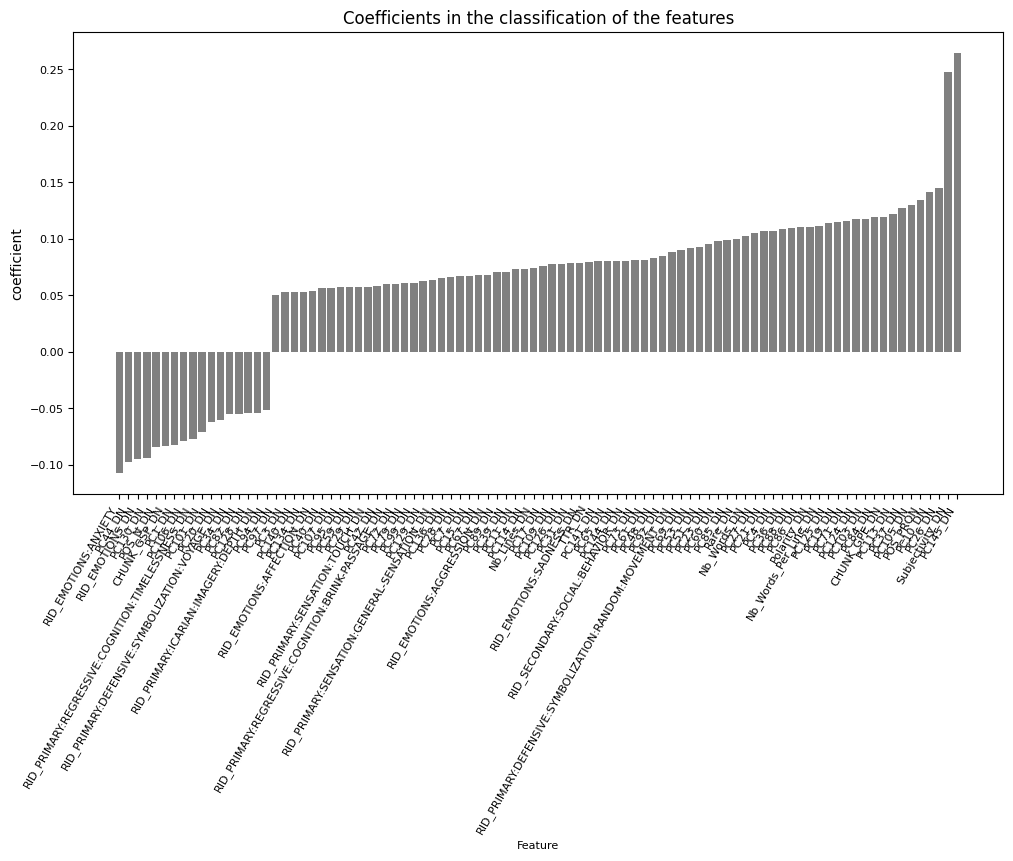

446


<Figure size 640x480 with 0 Axes>

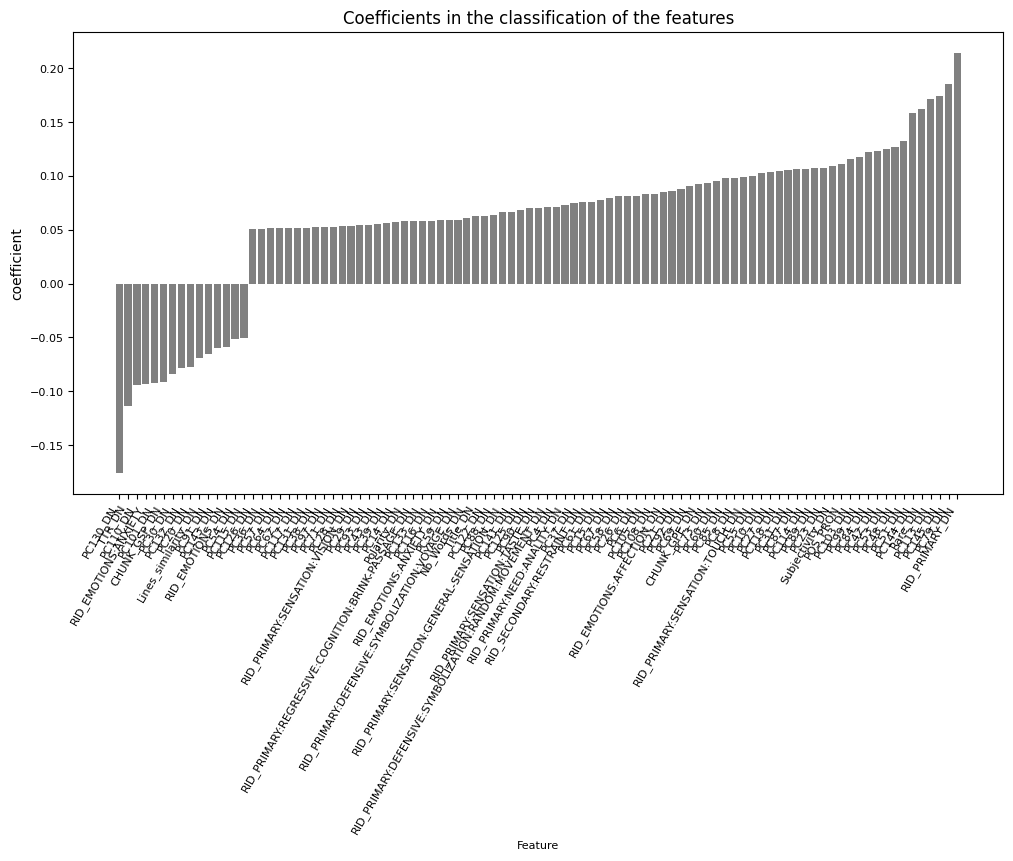

446


<Figure size 640x480 with 0 Axes>

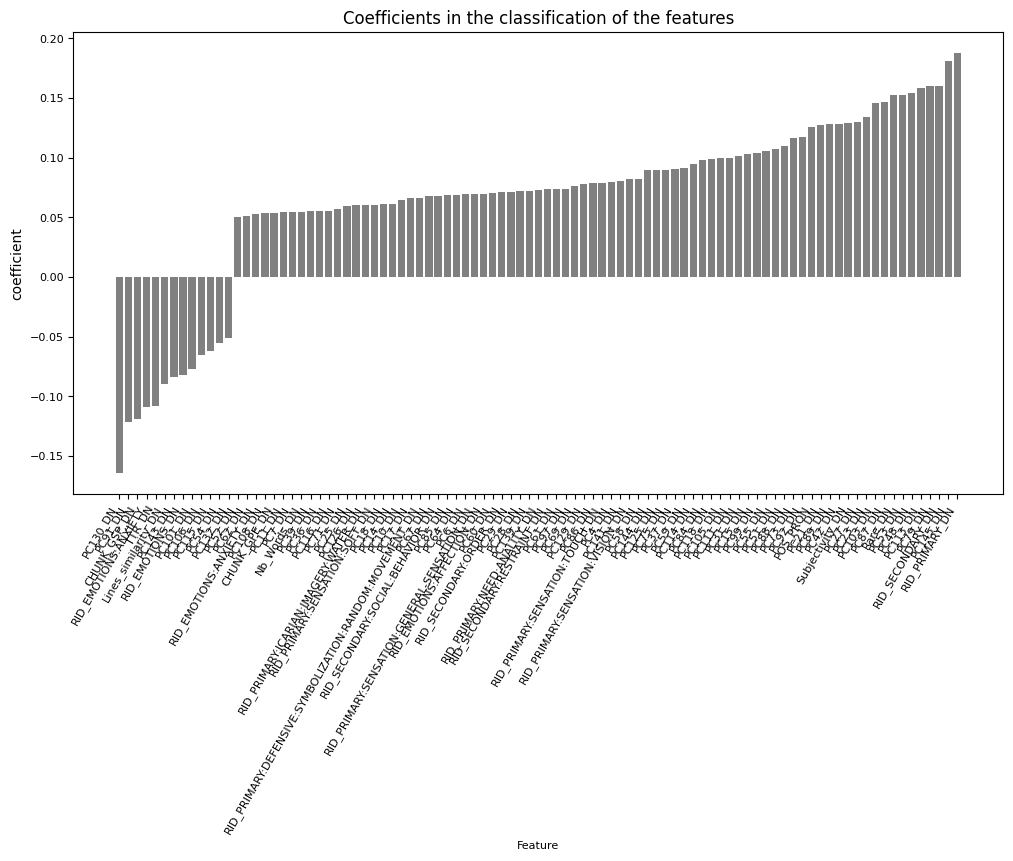

<Figure size 640x480 with 0 Axes>

In [251]:
feature_imp1(crrsave, fts)

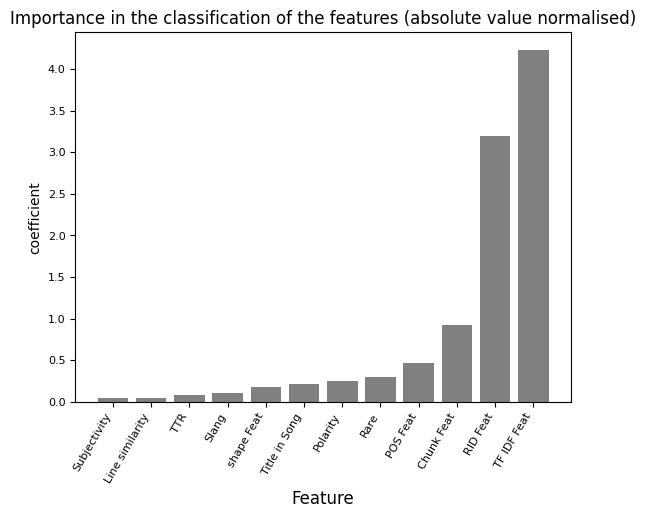

<Figure size 640x480 with 0 Axes>

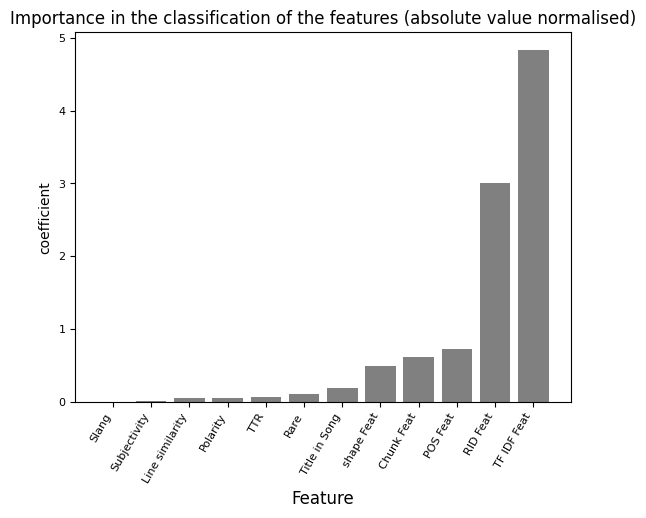

<Figure size 640x480 with 0 Axes>

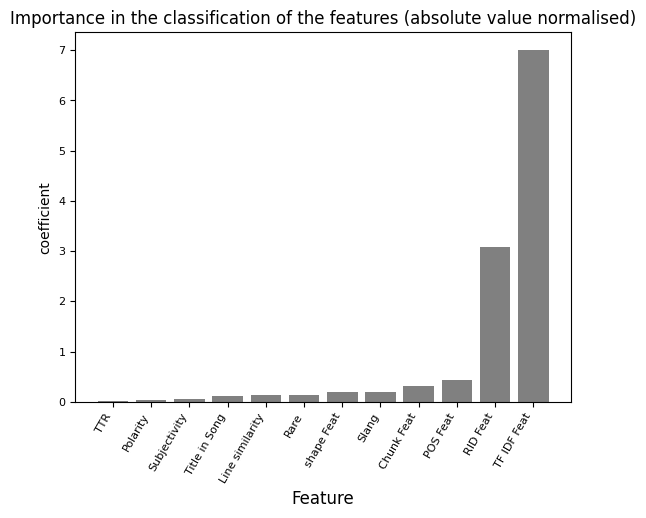

<Figure size 640x480 with 0 Axes>

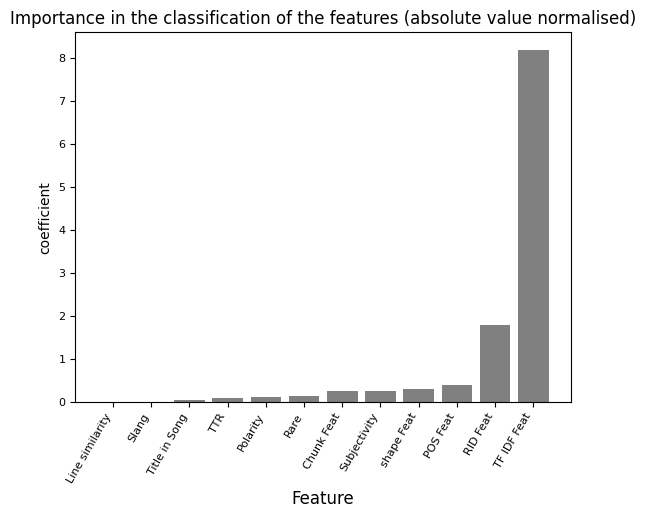

<Figure size 640x480 with 0 Axes>

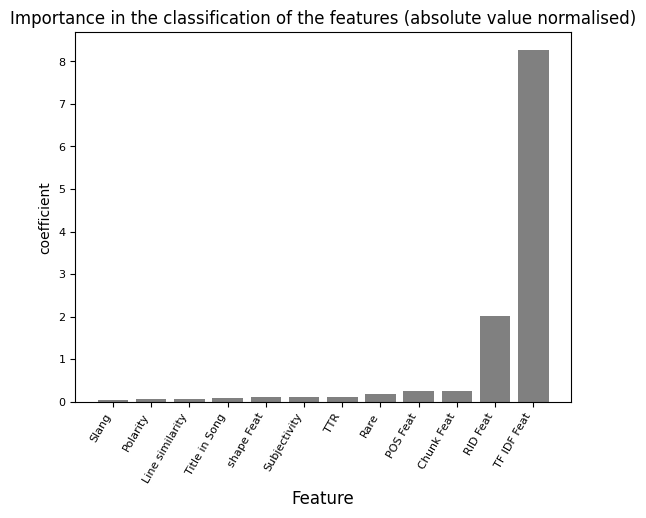

<Figure size 640x480 with 0 Axes>

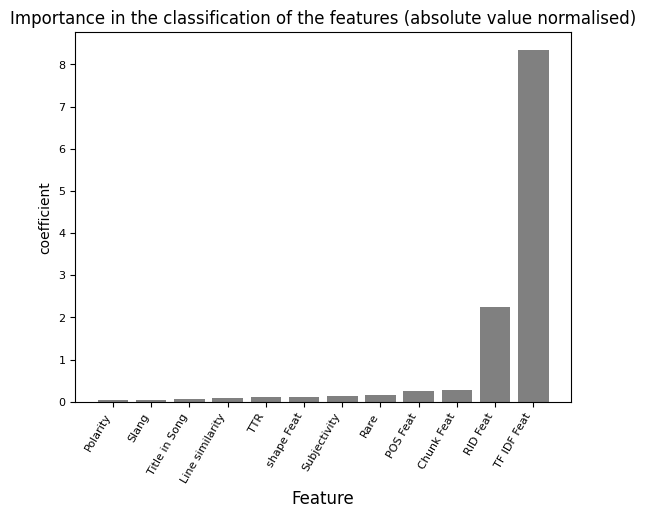

<Figure size 640x480 with 0 Axes>

In [247]:
feature_imp2(crrsave, fts)

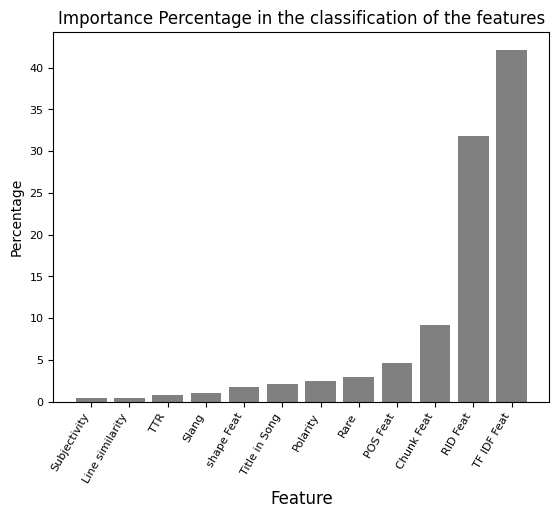

<Figure size 640x480 with 0 Axes>

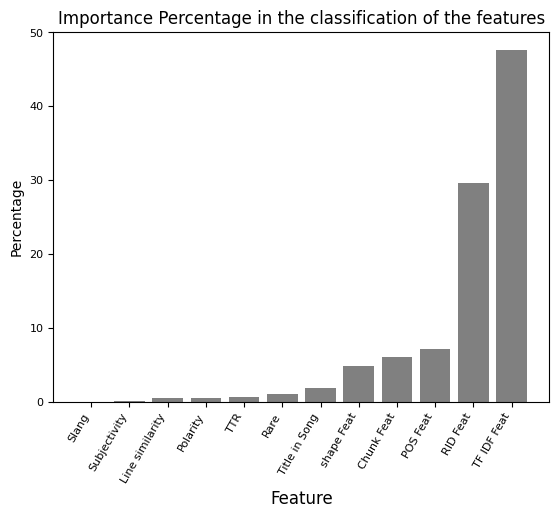

<Figure size 640x480 with 0 Axes>

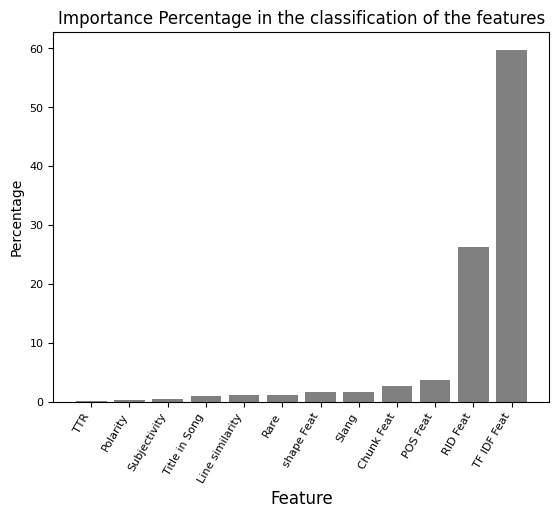

<Figure size 640x480 with 0 Axes>

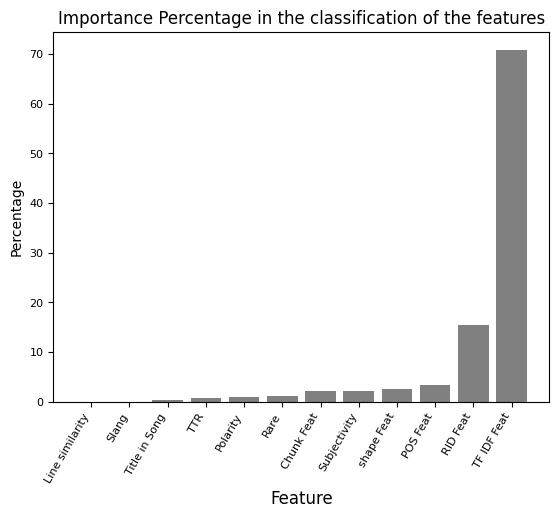

<Figure size 640x480 with 0 Axes>

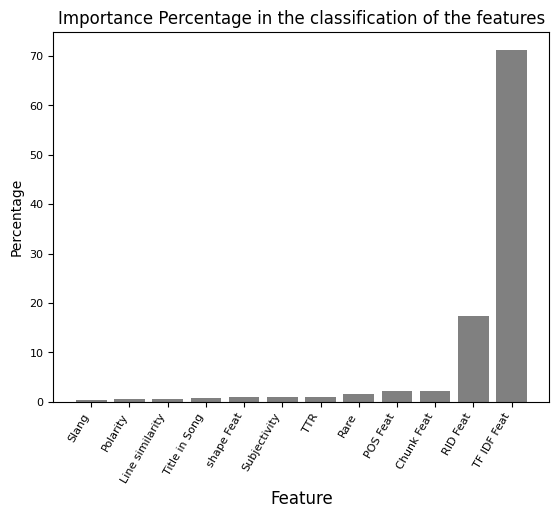

<Figure size 640x480 with 0 Axes>

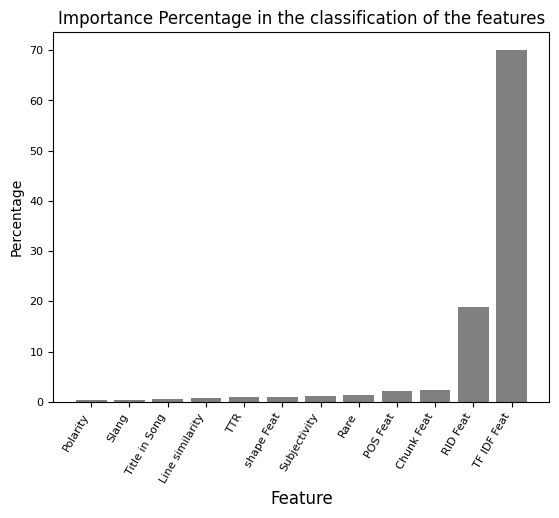

<Figure size 640x480 with 0 Axes>

In [248]:
feature_imp3(crrsave, fts)

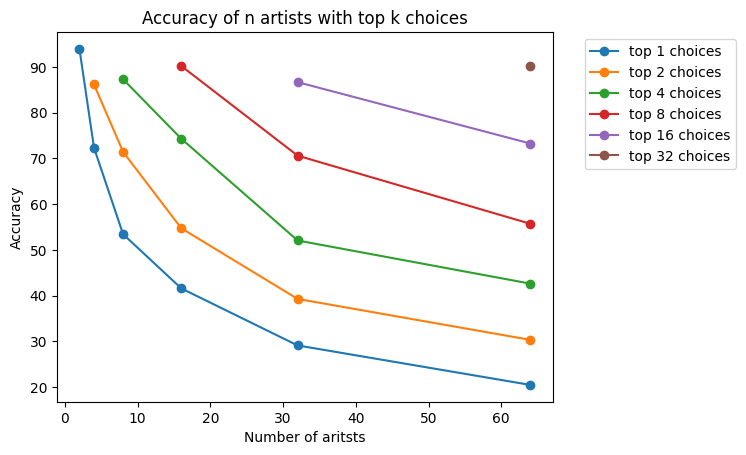

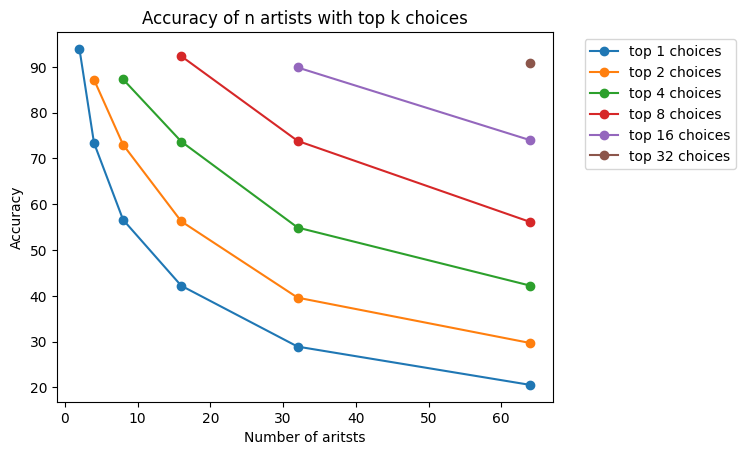

446


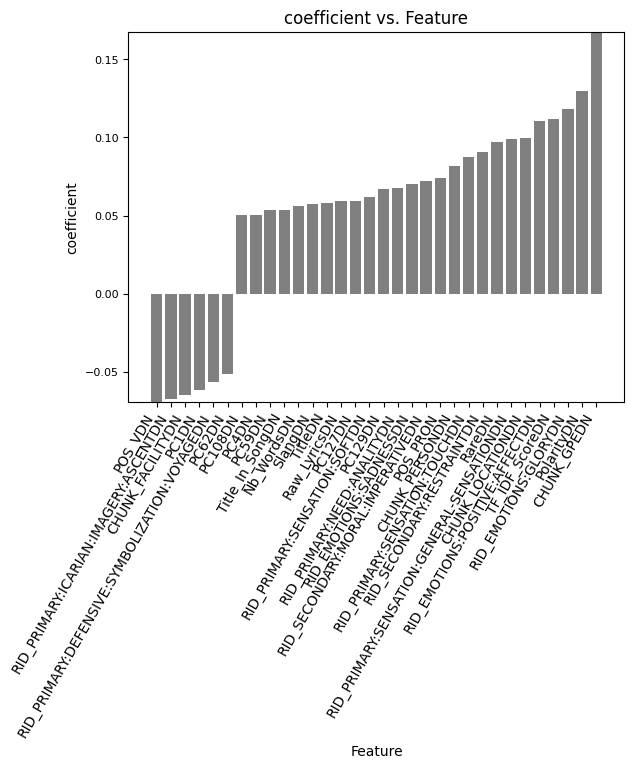

446


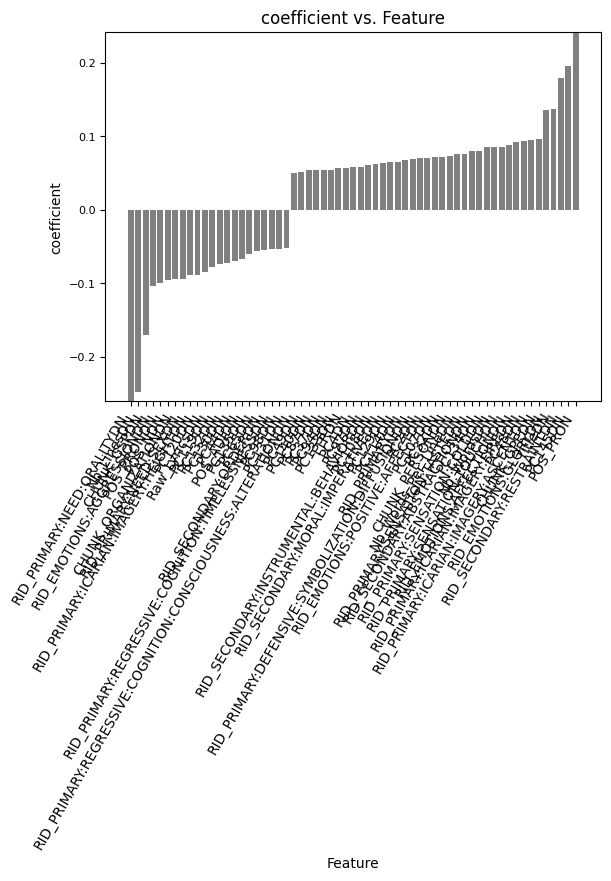

446


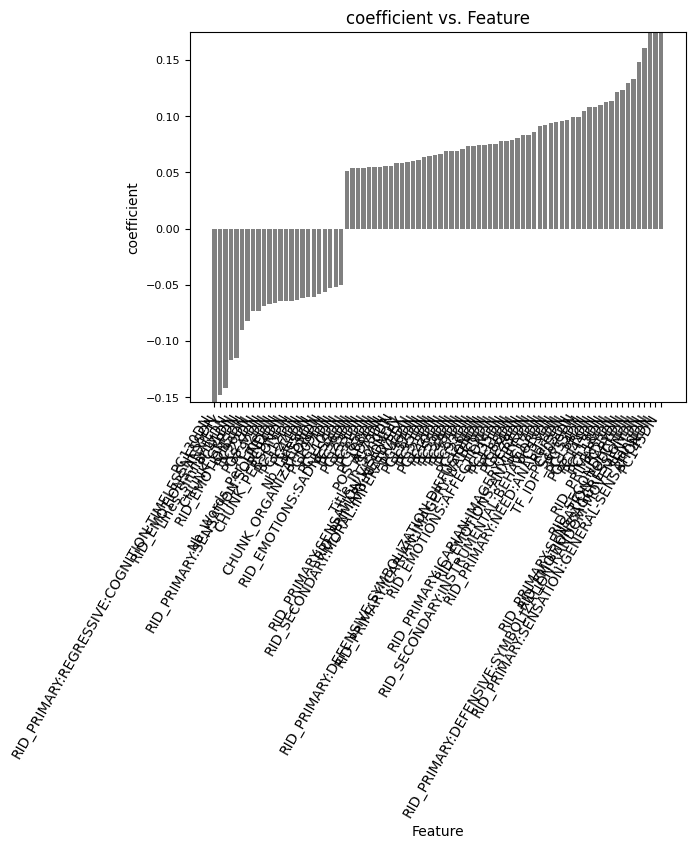

446


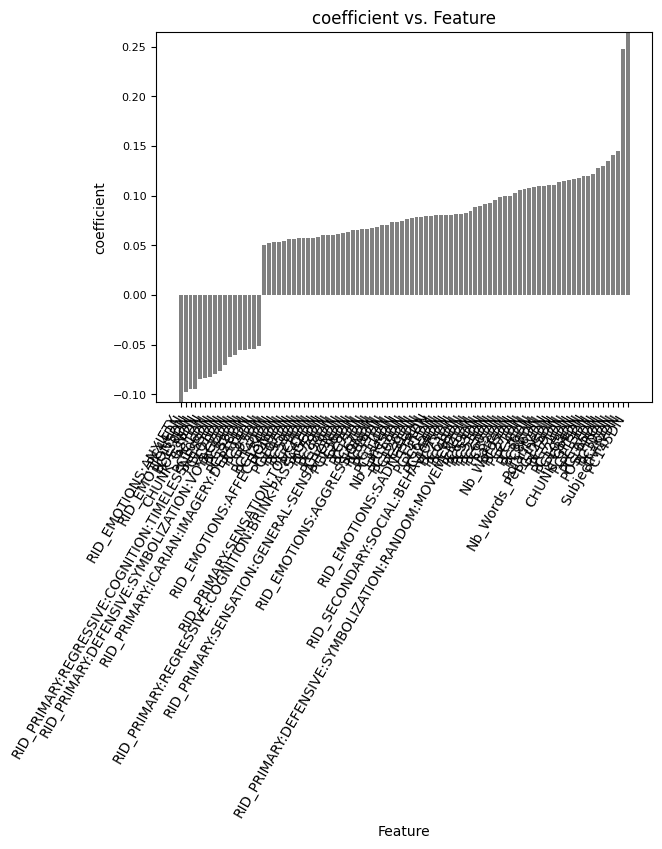

446


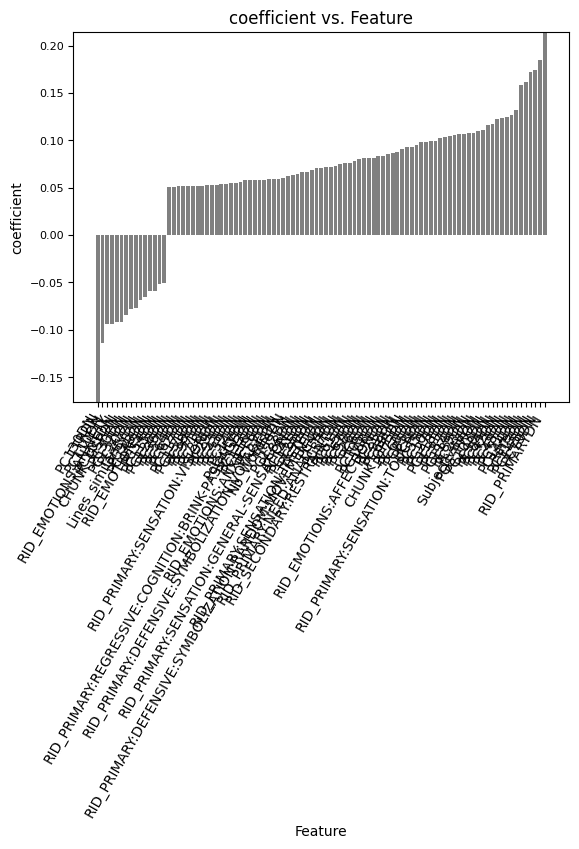

446


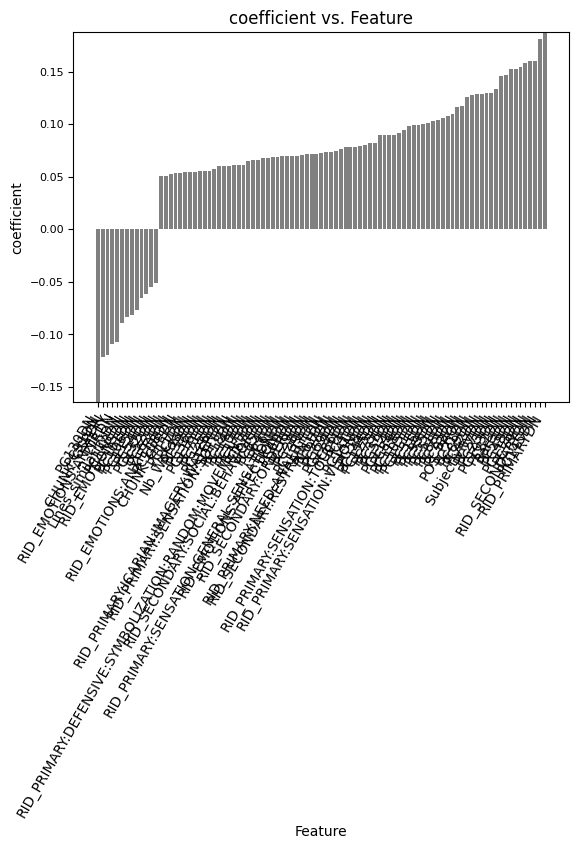

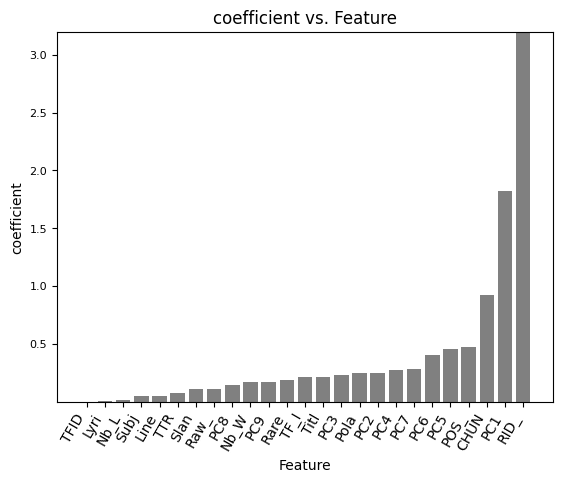

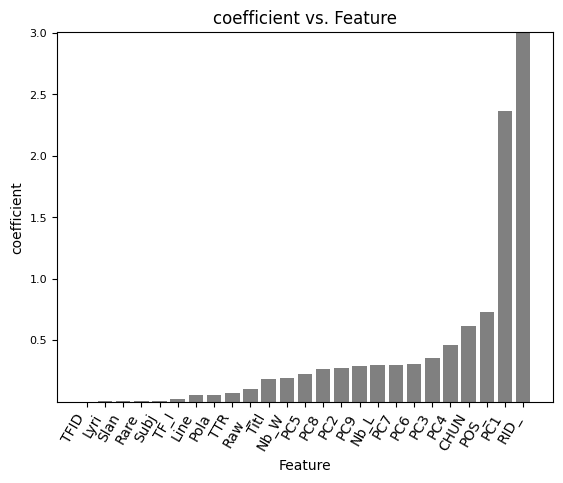

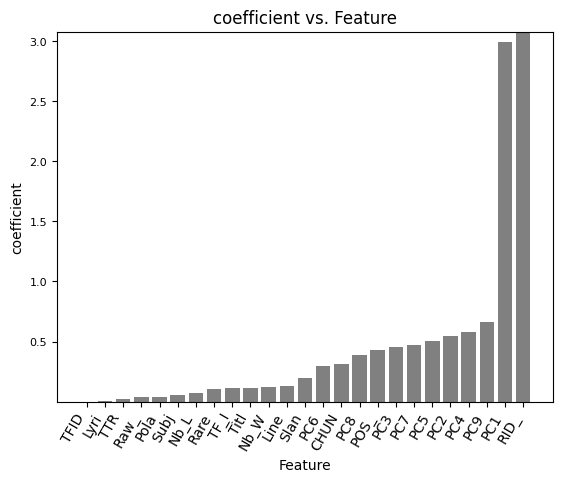

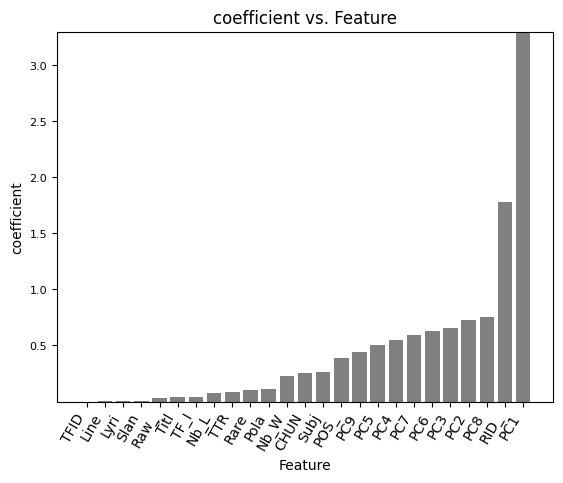

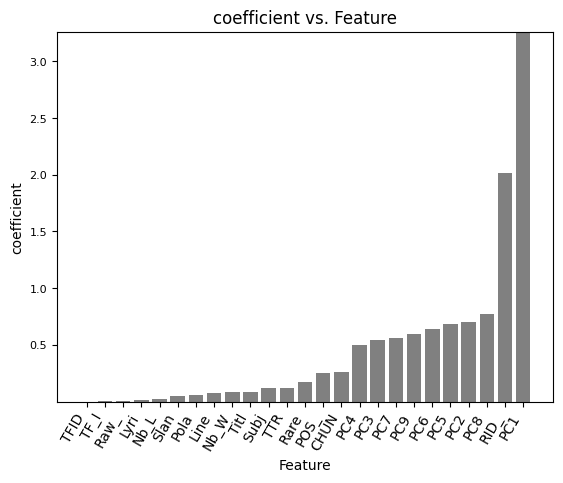

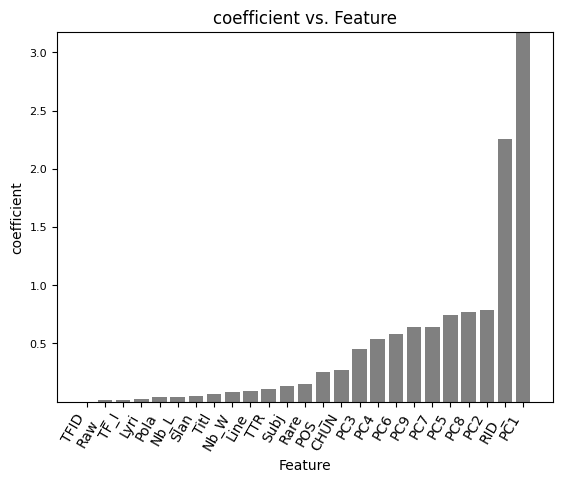

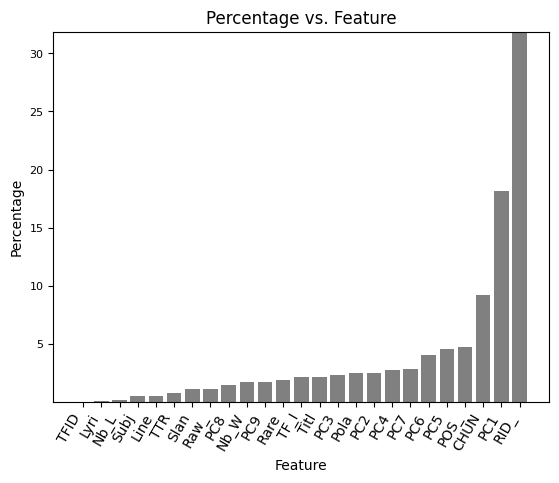

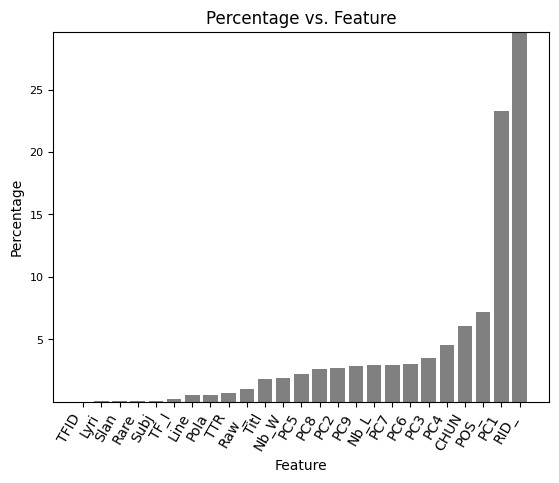

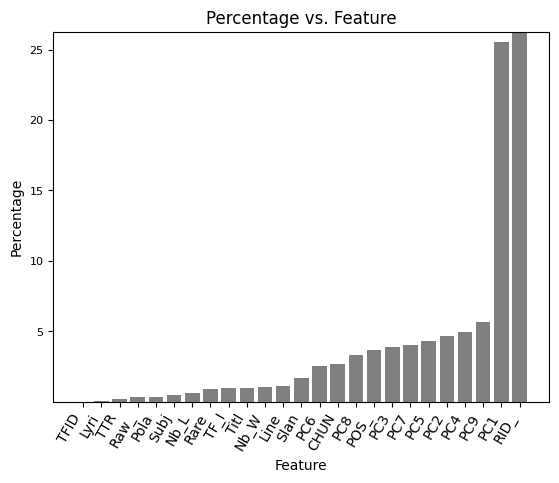

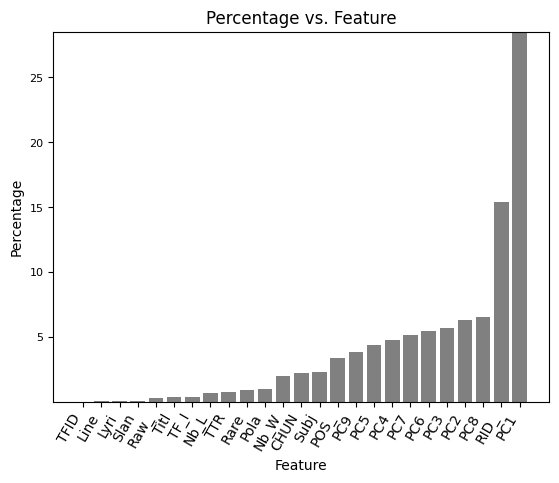

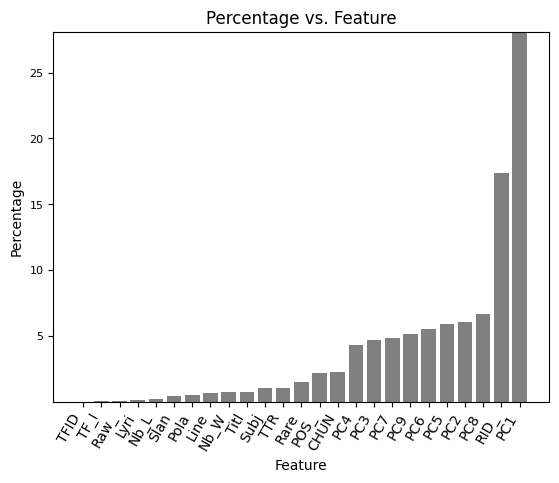

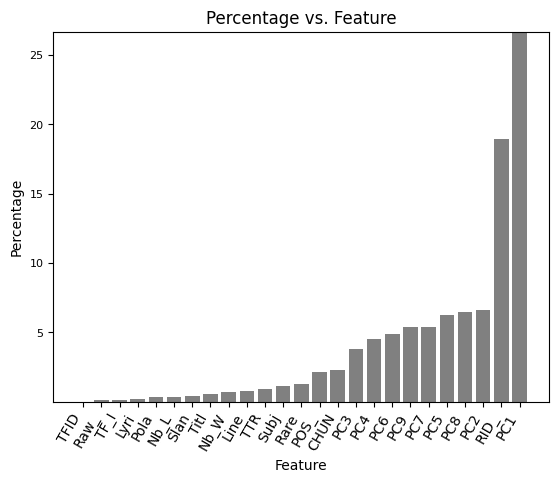

<Figure size 640x480 with 0 Axes>

In [153]:
plot_top_tog(brr = brr, nlist =nlist, top = top)
plot_top_tog(brr = brrlog, nlist =nlist, top = top)
feature_imp1(crr=crr, fts = fts)
feature_imp2(crr=crr, fts = fts)
feature_imp3(crr=crr, fts = fts)